## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))


**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [2]:
import sktime
import statsmodels as sm
import matplotlib 
import scipy 

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
''')


sktime ->  0.11.0
Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.21.5
scipy -> 1.7.3
statsmodels -> 0.13.2



In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
path = Path('../../datasets/Ch12/')
# Read the daily_weather.csv 

daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_weather.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [5]:
daily_weather.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

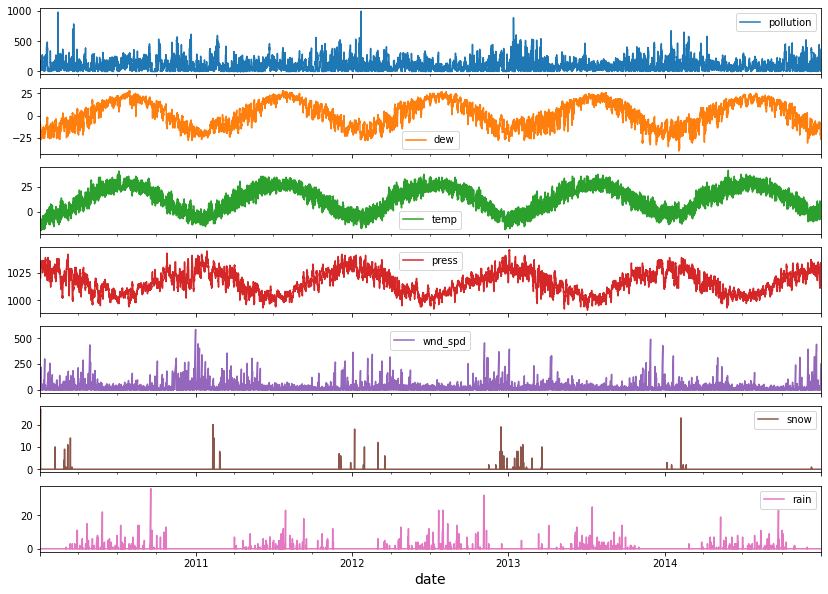

In [6]:
pollution = pd.read_csv(path.joinpath('air_pollution.csv'), index_col='date', parse_dates=True, infer_datetime_format=True)
pollution.plot(subplots=True, figsize=(14, 10));

In [7]:
print(daily_weather.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

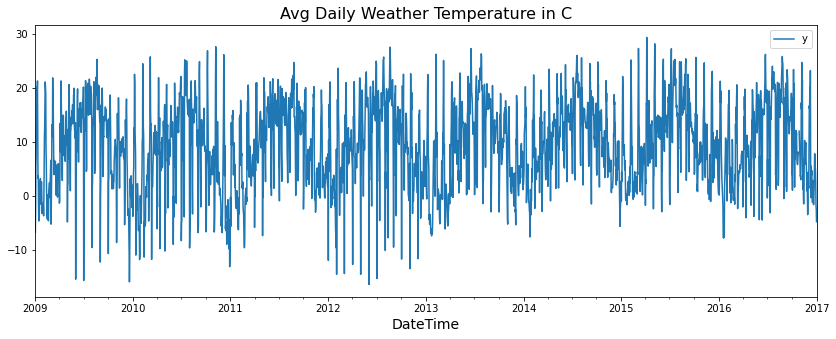

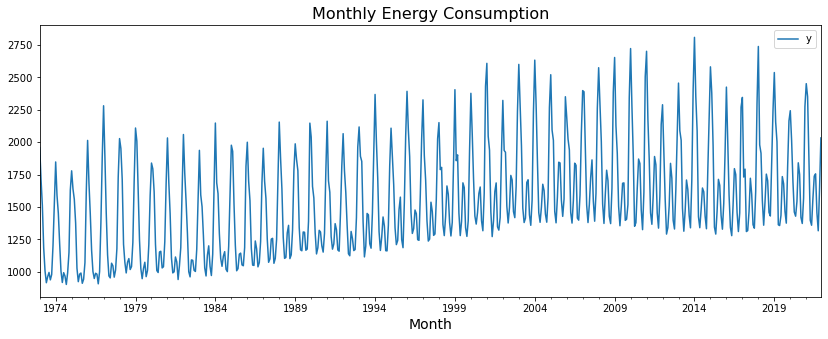

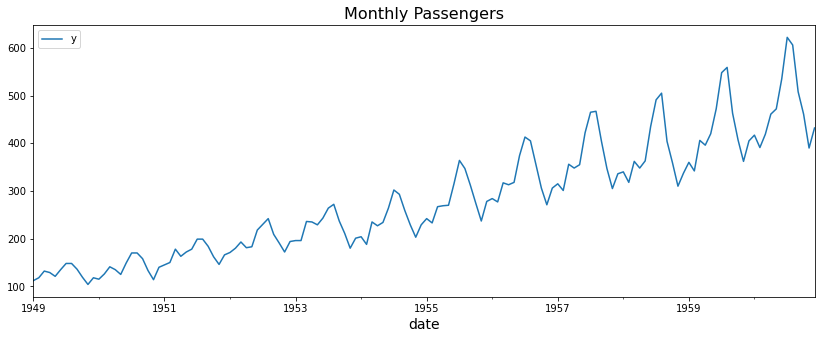

In [8]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

# Preparing Time Series for Supervised Machine Learning

In [686]:
air_copy = air.copy()
energy_copy = energy.copy()
daily_weather_copy = daily_weather.copy()

In [9]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [688]:
for df in [air_copy, energy_copy, daily_weather_copy]:
    handle_missing_data(df)

found 2 missing observations...


In [689]:
daily_weather_copy.isna().sum()

y    0
dtype: int64

In [10]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [691]:
air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_weather_os = one_step_forecast(daily_weather_copy, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_weather_os.shape)

(139, 6)
(583, 6)
(2918, 6)


In [692]:
air_os.head()

x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119

In [11]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [31]:
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 119 Test: 20


In [12]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [33]:
scaler = Standardize()
train, test = scaler.fit_transform(air_os)

In [34]:
y_train_original = scaler.inverse_y(train['y'])

In [35]:
train_original = scaler.inverse(train)

## There is more

In [13]:
class Stationrize:
    def __init__(self):
        pass
    
    def check_stationarity(self, data):
        if adfuller(data)[1] < 0.05:
            self.status = "Stationary"
        else:
            self.status = "Non Stationary"
        return self.status
            
    def transform(self, df, order=1):
        status = self.check_stationarity(df)
        if status != 'Stationary':
            self.shifted = df.shift(periods=order)
            return (df - self.shifted).dropna()
        else:
            return df
    
    def inverse(self, df):
        return df + self.shifted


# Forecasting using Linear Regression Models with Scikit-Learn

## How to do it..

In [14]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)

In [14]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_weather.copy()

### Preprocessing Time Series Data

In [15]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [16]:
air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)

In [17]:
print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)

(134, 11)
(578, 11)
(2913, 11)


In [15]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [19]:
train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

In [20]:
train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

In [21]:
train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_en.fit_transform(train_dw,test_dw)

### Train

In [16]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [79]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [17]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [84]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


### Evaluate

In [85]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.210168  1.390807
0  Linear Regression  0.385559  0.213810  1.411072
4   Huber Regression  0.400949  0.226859  1.457932
1        Elastic Net  0.829023  0.406390  2.808737
3   Lasso Regression  1.190006  0.780255  4.439302

In [86]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  0.729910  0.525526
2   Ridge Regression  0.433192  0.819432  0.560450
0  Linear Regression  0.433747  0.818459  0.560989
1        Elastic Net  0.747657  1.398025  1.013425
3   Lasso Regression  0.834356  1.502494  1.108092

In [87]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  0.697774  0.968735
0  Linear Regression  0.646648  0.735055  0.990057
2   Ridge Regression  0.646639  0.735072  0.990085
1        Elastic Net  0.737896  1.075669  1.300792
3   Lasso Regression  0.814609  1.304278  1.468567

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

#### Air Passengers Plots

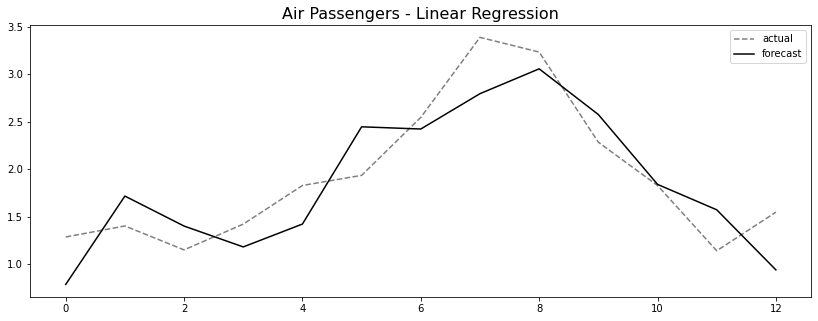

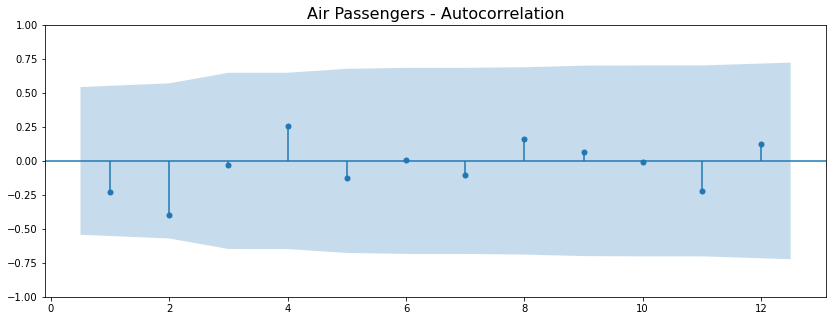

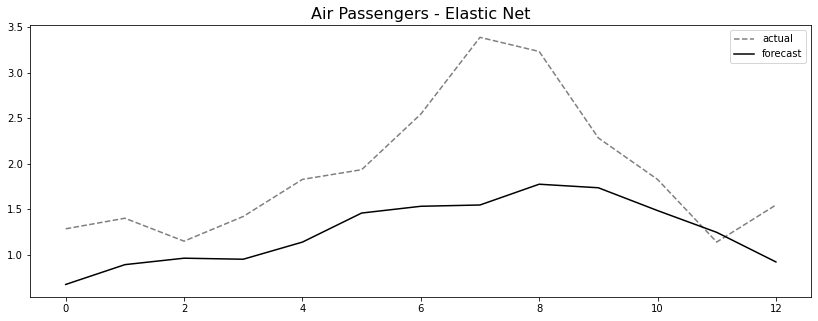

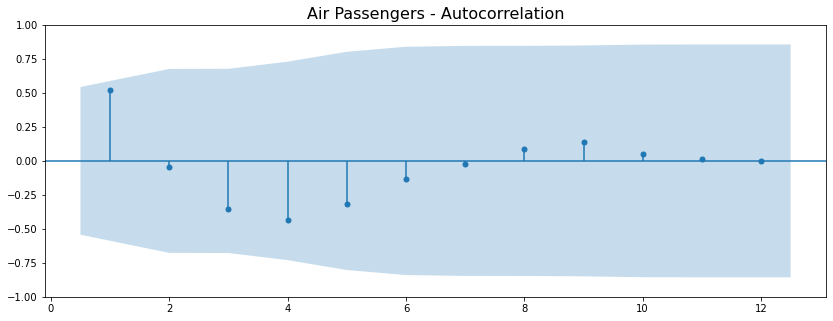

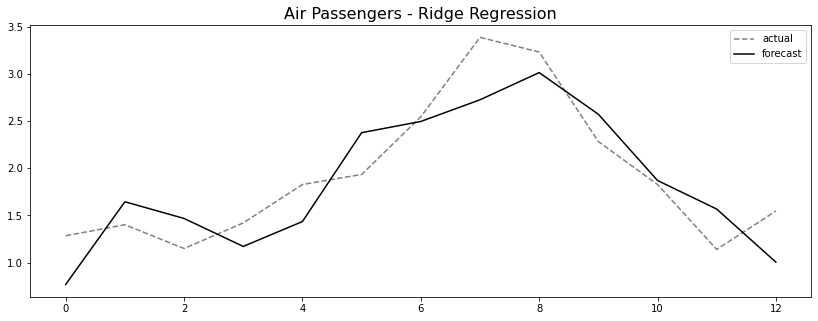

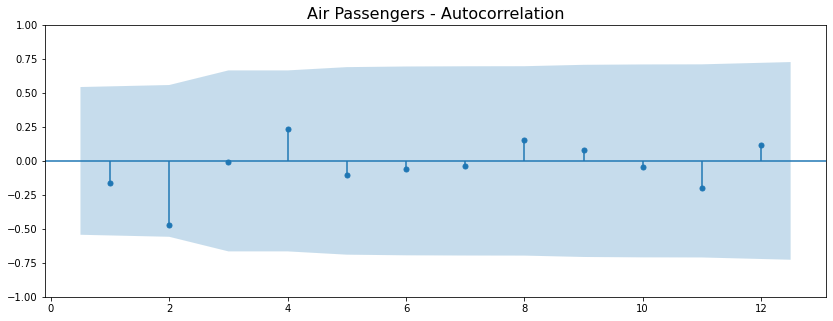

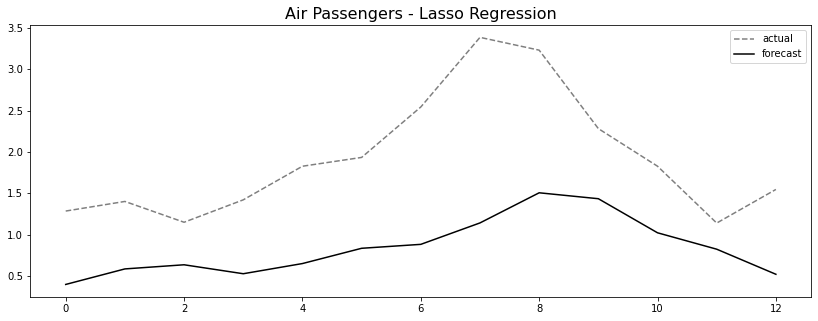

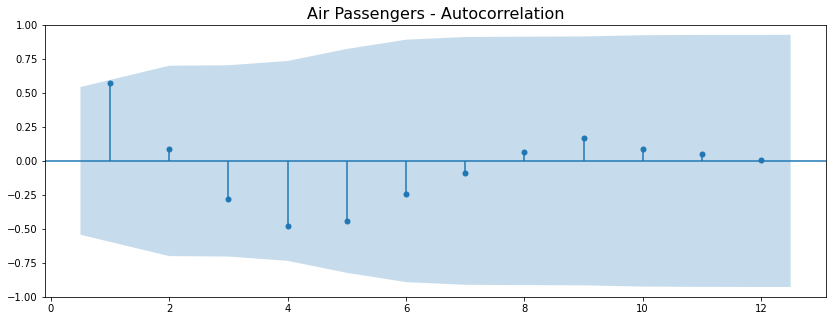

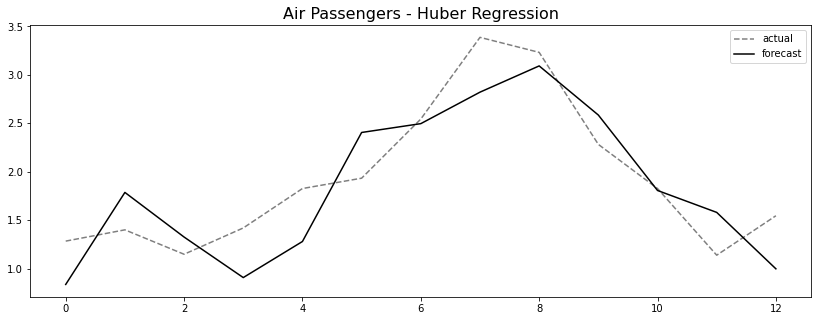

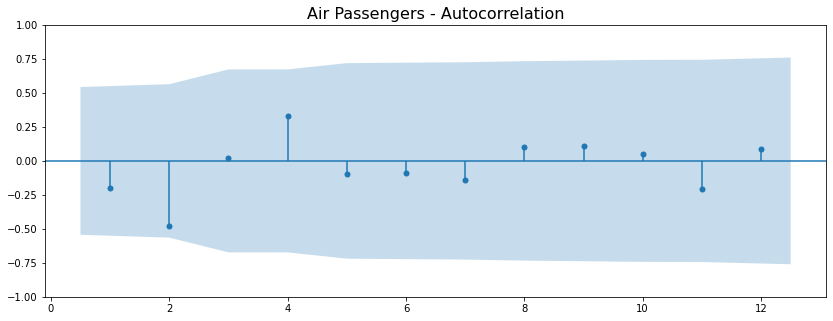

In [38]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


#### Energy Consumption Plots

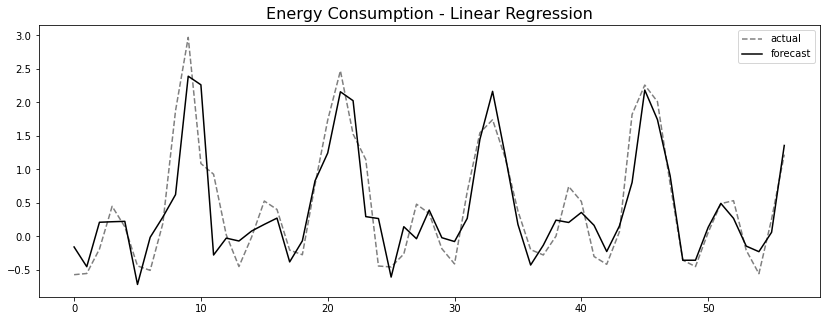

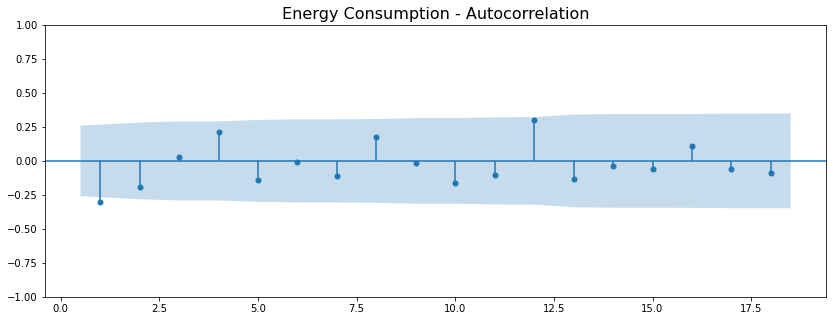

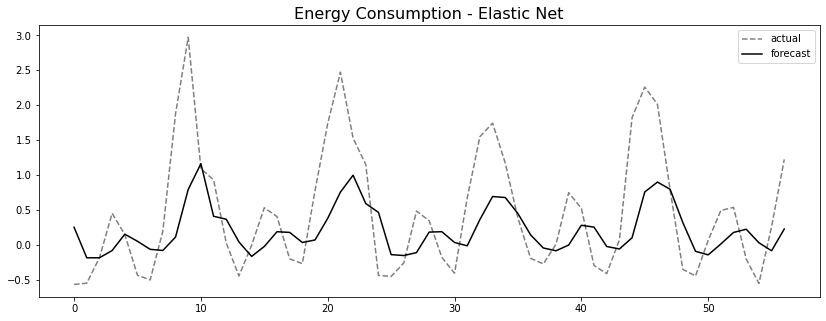

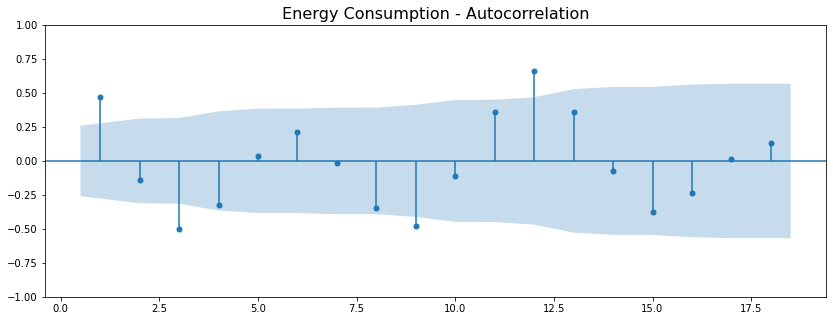

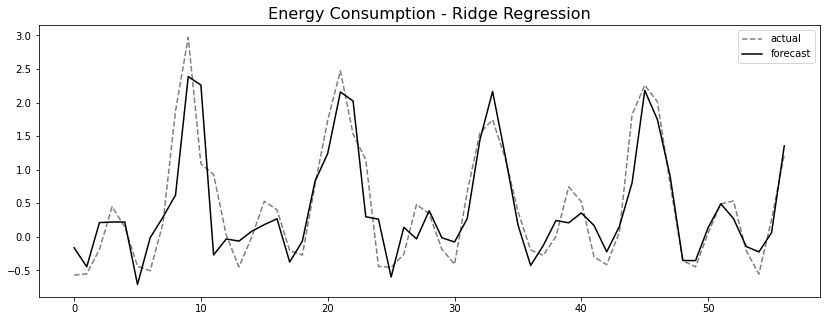

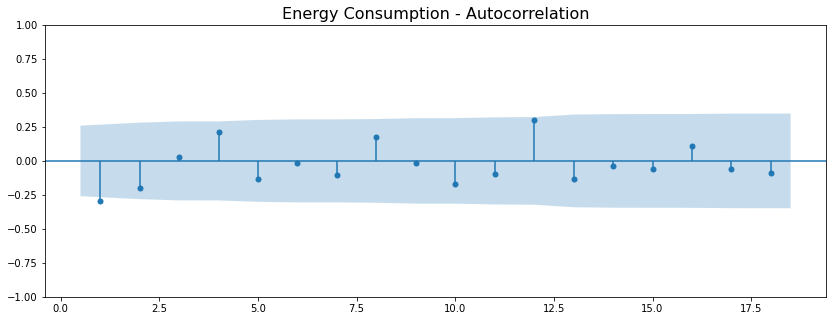

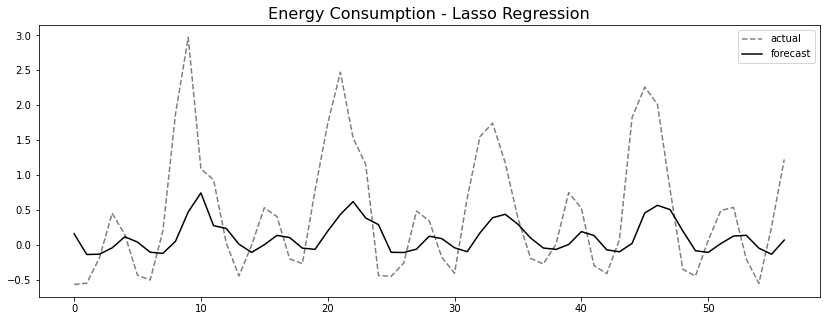

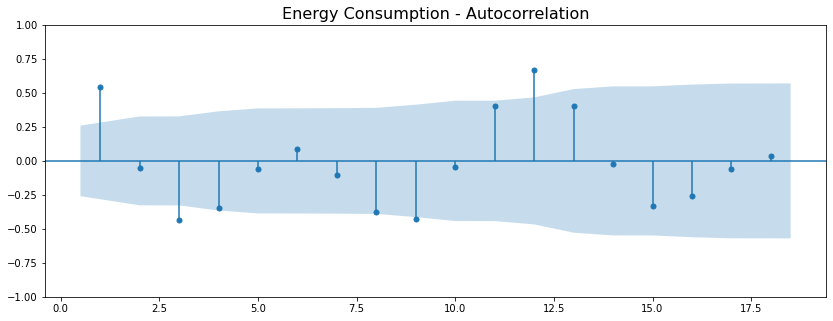

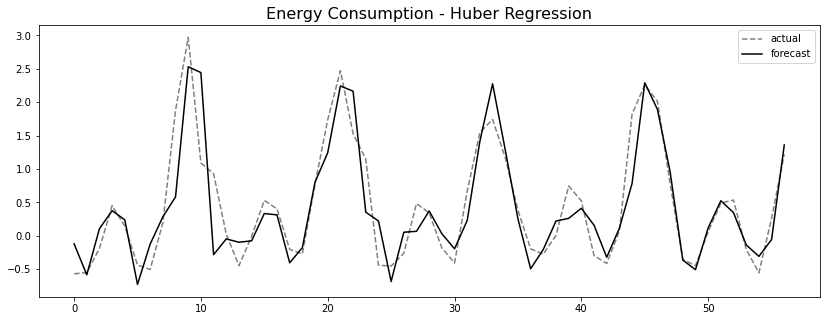

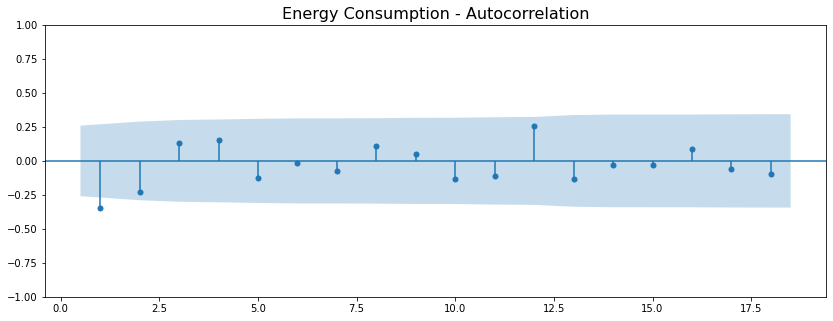

In [39]:
plot_results(cols, en_results, 'Energy Consumption')

#### Daily Temperature Plots

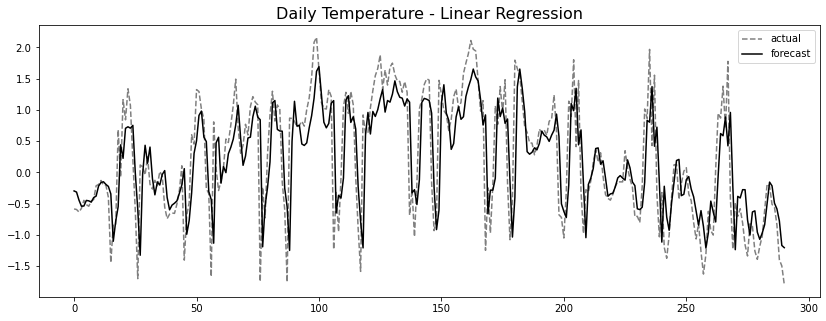

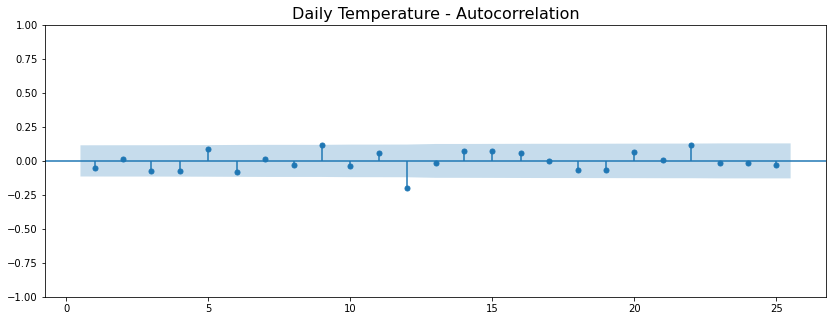

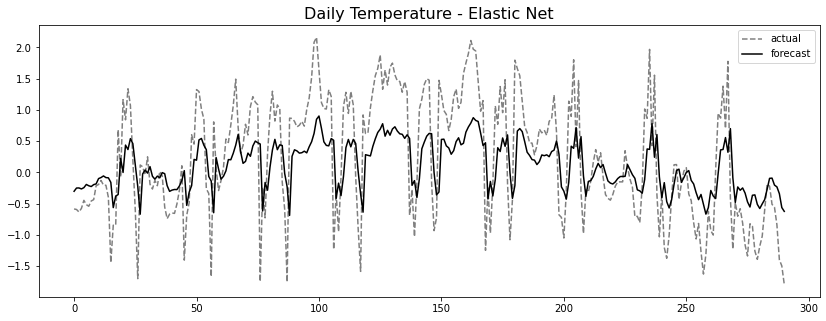

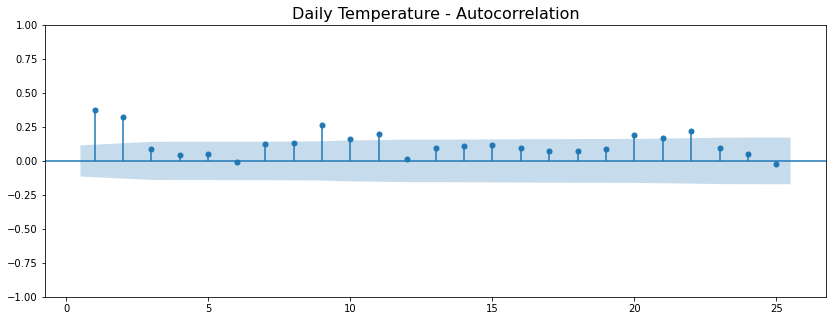

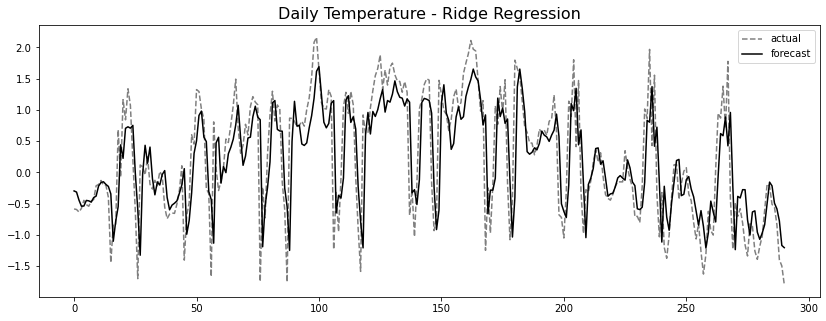

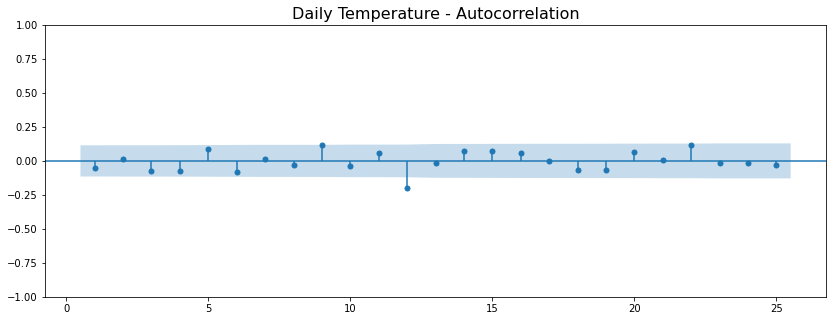

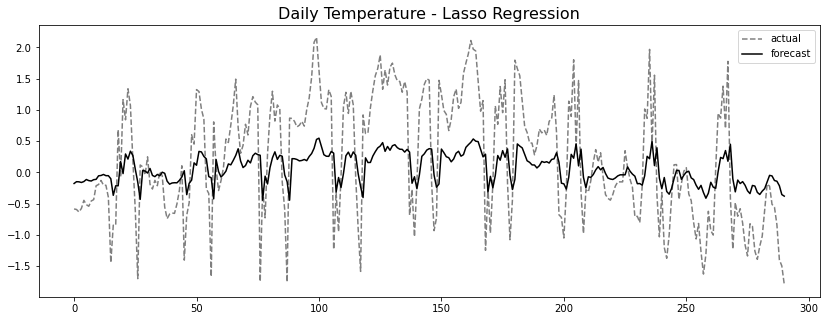

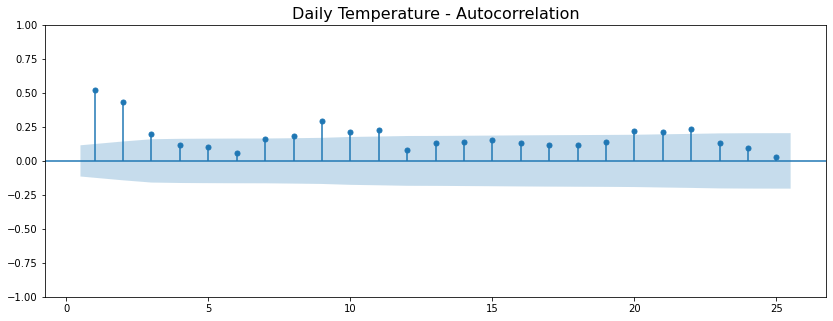

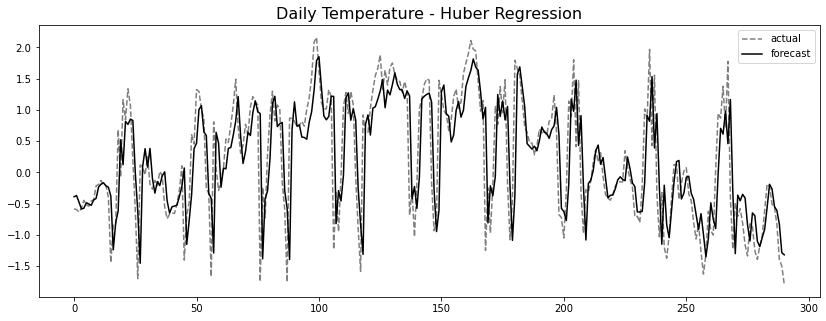

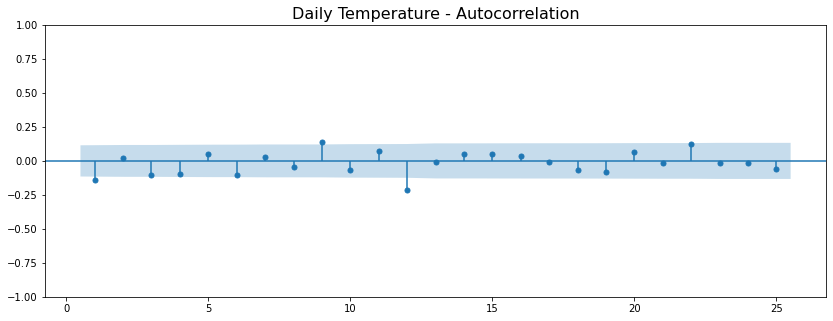

In [40]:
plot_results(cols, dw_results, 'Daily Temperature')

## How it works

In [43]:
cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


### Energy Consumption

**Regression Coefficients and Feature Selection**

In [45]:
en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  0.729910  0.525526
2   Ridge Regression  0.433192  0.819432  0.560450
0  Linear Regression  0.433747  0.818459  0.560989
1        Elastic Net  0.747657  1.398025  1.013425
3   Lasso Regression  0.834356  1.502494  1.108092

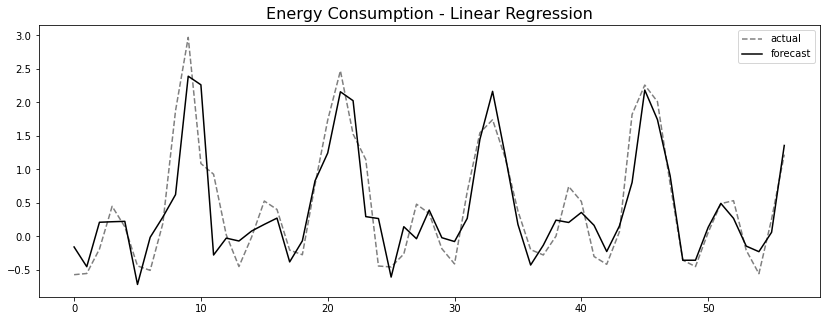

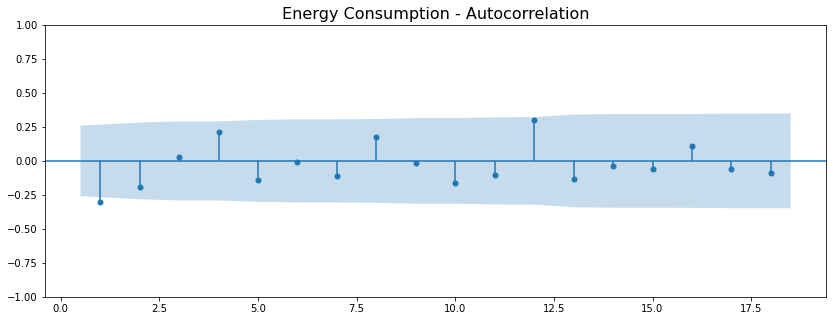

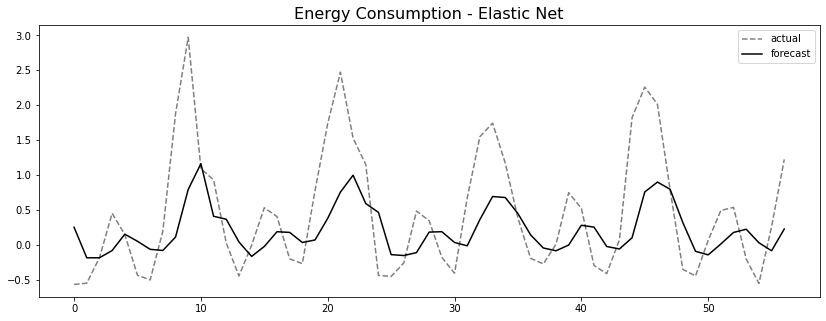

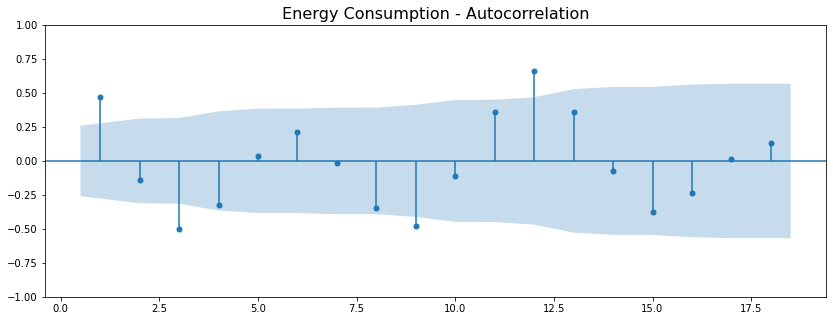

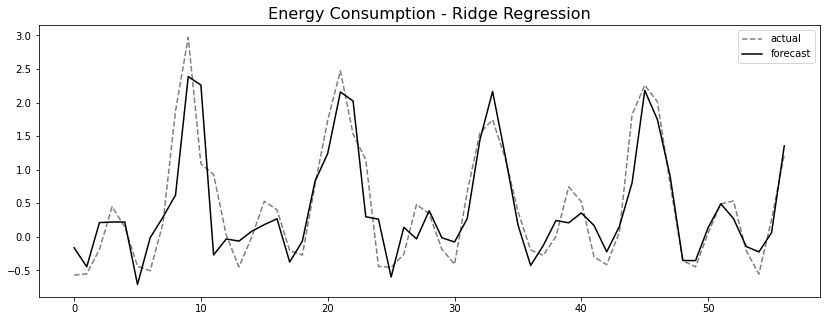

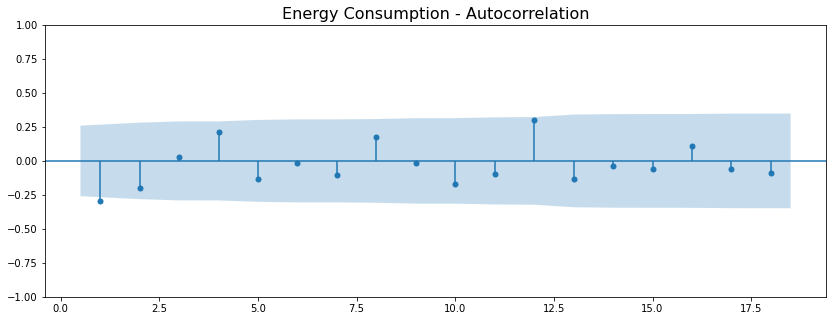

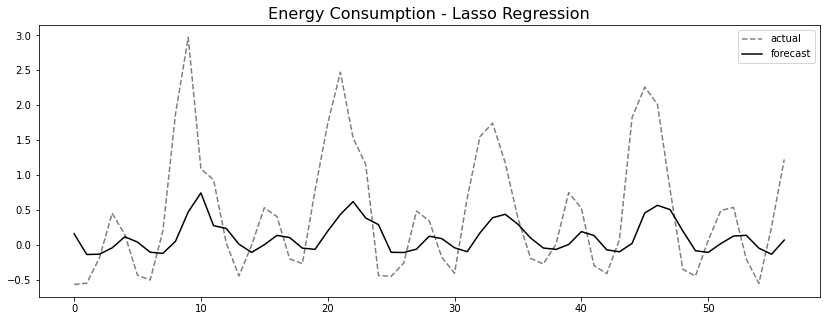

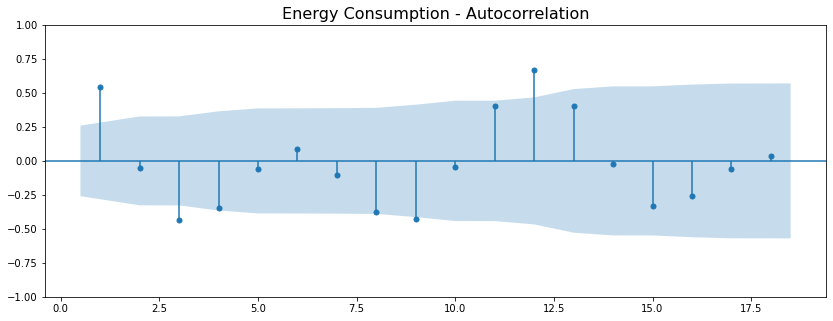

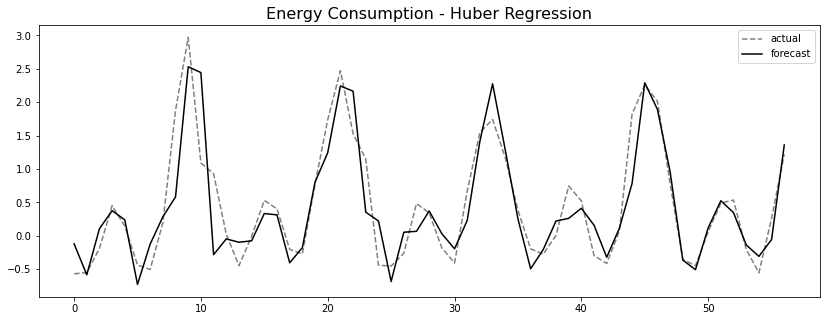

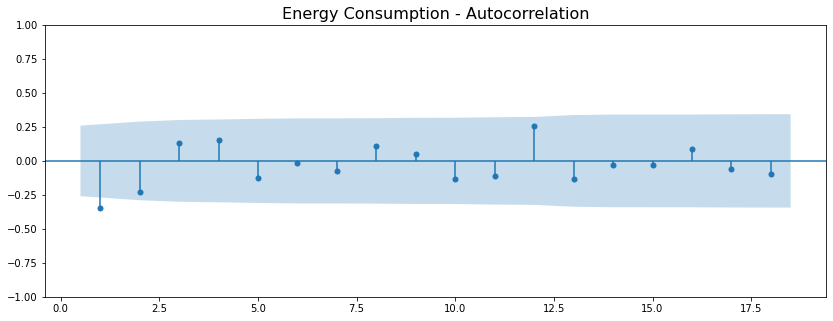

In [46]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')

In [75]:
cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]


## There is more

In [312]:
lr = LinearRegression(fit_intercept=False)

In [319]:
dw_cp = daily_weather.copy()
handle_missing_data(dw_cp)

found 2 missing observations...


In [322]:
dw_os = one_step_forecast(dw_cp, 10)

In [323]:
train_dw, test_dw = split_data(dw_os)

In [326]:
scale_dw = Standardize()
train_dw, test_dw = scale_dw.fit_transform(train_dw, test_dw)

In [334]:
X_train, y_train = train_dw.drop(columns=['y']), train_dw['y']
X_test, y_test = test_dw.drop(columns=['y']), test_dw['y']

In [335]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(2477, 10)
(2477,)
(436, 10)
(436,)


In [522]:
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [523]:
lr.coef_

array([ 0.02617076,  0.02303296,  0.04206657,  0.06380964,  0.01996243,
       -0.08914537,  0.03237378, -0.14038229,  0.14175303,  0.703715  ])

In [524]:
predict_all = lr.predict(X_test)
scale_dw.inverse_y(predict_all)[-5:]

array([ 5.36341329,  4.64328016,  3.16434622,  0.09907001, -0.16098541])

In [526]:
last_10_days = X_test.iloc[[-1]]
scale_dw.inverse_y(last_10_days)

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-22 -0.007361  1.237056  4.528661  7.790783  7.519598  5.237864   

                x_7       x_8       x_9      x_10  
DateTime                                           
2016-12-22  4.88254  2.671846 -1.716136 -2.503419

In [528]:
# Actual
scale_dw.inverse_y(y_test.iloc[-1])

-4.83550722602835

In [529]:
dw_os.iloc[[-1]]

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-22 -0.007361  1.245069  4.539514  7.798611  7.527431  5.245625   

                 x_7      x_8       x_9    x_10     y  
DateTime                                               
2016-12-22  4.887153  2.67625 -1.706597 -2.4925 -4.82

In [593]:
last_10_days

array([-4.18805815e-03,  1.24035033e+00,  4.53227688e+00,  7.79471681e+00,
        7.52350583e+00,  5.24154917e+00,  4.88618995e+00,  2.67528068e+00,
       -1.71312921e+00, -2.50048957e+00])

In [530]:
predict_one = lr.predict(last_10_days)
predicted = scale_dw.inverse_y(predict_one)
predicted

array([-0.16098541])

In [531]:
dw_cp[-11:]

y
DateTime            
2016-12-22 -0.007361
2016-12-23  1.245069
2016-12-24  4.539514
2016-12-25  7.798611
2016-12-26  7.527431
2016-12-27  5.245625
2016-12-28  4.887153
2016-12-29  2.676250
2016-12-30 -1.706597
2016-12-31 -2.492500
2017-01-01 -4.820000

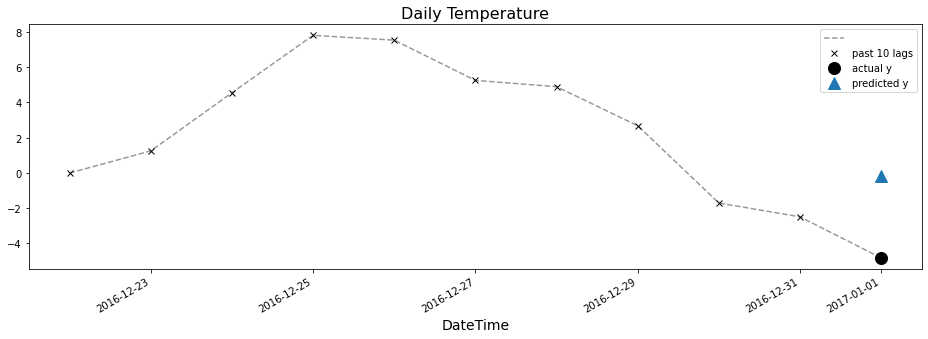

In [532]:
last_segment = dw_cp.iloc[-11:].copy()

plt.title('Daily Temperature')
d = pd.Series([0], index=pd.date_range('2017-01-02', freq='MS', periods=1))
ax = pd.concat([last_segment, d])['y'].plot(style='k--', alpha=0.4)

dw_cp.iloc[-11:-1].plot(style='kx', ax=ax)
dw_cp.iloc[-1:].plot(style='ko', ax=ax, markersize=12)
pd.Series(predicted, index=pd.DatetimeIndex(['2017-01-01'])).plot(style='^', markersize='12', ax=ax)

plt.legend(['','past 10 lags', 'actual y', 'predicted y'])
plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig12.6.png', bbox_inches='tight', dpi=600)

In [459]:
xtest

x_1    -0.714191
x_2    -0.595574
x_3    -0.824978
x_4    -1.170329
x_5    -1.346685
x_6    -0.834812
x_7    -0.873757
x_8    -1.266852
x_9    -1.399204
x_10   -1.189356
Name: 2016-12-13 00:00:00, dtype: float64

In [457]:
xtest = X_test.iloc[-10]
xtest.tolist()

[-0.7141912924235726,
 -0.5955743302745886,
 -0.8249782574207956,
 -1.1703287435615477,
 -1.3466846832237651,
 -0.8348115572934125,
 -0.8737570184811081,
 -1.2668515617665892,
 -1.3992037143626295,
 -1.189355946988441]

In [430]:
a = np.array([1,2,3,4,5])
b = np.roll(a, -1)

In [443]:
a = [1,2,3,4,5]

In [446]:
a.pop(0)
a.append(6)
a

[3, 4, 5, 6, 6]

In [468]:
c = np.array([1,2,3])

### Multi-Step Forecasting

In [568]:
def multi_step(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

In [569]:
dw_ms = X_test.iloc[-1].tolist()
pred = multi_step(dw_ms, steps=10, model=lr)
pred

array([-1.20806198, -0.91824263, -0.65182974, -0.42917882, -0.2952679 ,
       -0.28149583, -0.33263402, -0.40159773, -0.45535939, -0.46943457])

In [570]:
def multi_step(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(data.reshape(1,-1))[0]
        forecast.append(one_step_pred)
        data = np.roll(data, shift=-1)
        data[-1] = one_step_pred
    return np.array(forecast)

In [571]:
dw_ms = X_test.iloc[-1].values
pred = multi_step(dw_ms, steps=10, model=lr)
pred

array([-1.20806198, -0.91824263, -0.65182974, -0.42917882, -0.2952679 ,
       -0.28149583, -0.33263402, -0.40159773, -0.45535939, -0.46943457])

In [572]:
pred = scale_dw.inverse_y(pred)

In [573]:
pred

array([-0.16098541,  2.1346783 ,  4.2449391 ,  6.00856061,  7.06927117,
        7.17835994,  6.77329352,  6.22703083,  5.80118385,  5.68969411])

In [574]:
scale_dw.inverse_y(y_test.iloc[-10:])

DateTime
2016-12-13    1.243023
2016-12-14    4.544779
2016-12-15    7.811110
2016-12-16    7.539327
2016-12-17    5.252457
2016-12-18    4.893190
2016-12-19    2.677380
2016-12-20   -1.715195
2016-12-21   -2.502842
2016-12-22   -4.835507
Freq: D, Name: y, dtype: float64

In [575]:
pred

array([-0.16098541,  2.1346783 ,  4.2449391 ,  6.00856061,  7.06927117,
        7.17835994,  6.77329352,  6.22703083,  5.80118385,  5.68969411])

In [576]:
X_test.iloc[-1]

x_1    -1.188667
x_2    -1.031564
x_3    -0.616011
x_4    -0.204180
x_5    -0.238416
x_6    -0.526476
x_7    -0.571335
x_8    -0.850427
x_9    -1.404394
x_10   -1.503786
Name: 2016-12-22 00:00:00, dtype: float64

In [577]:
dw_cp[-10:]

y
DateTime            
2016-12-23  1.245069
2016-12-24  4.539514
2016-12-25  7.798611
2016-12-26  7.527431
2016-12-27  5.245625
2016-12-28  4.887153
2016-12-29  2.676250
2016-12-30 -1.706597
2016-12-31 -2.492500
2017-01-01 -4.820000

#### Example on Daily Temperature Data

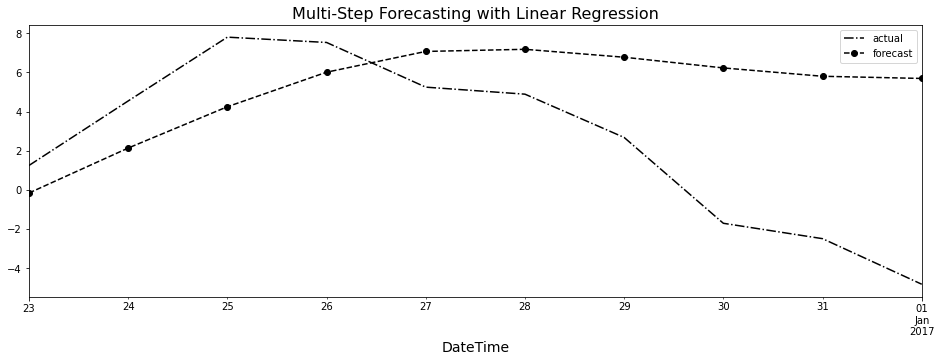

In [612]:
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=10, model=lr))
actual = dw_cp.iloc[-10:]
ax = actual.plot(style='k-.')
pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Linear Regression')
plt.legend(['actual', 'forecast'])
plt.show()

In [600]:
dw_ms = X_test.iloc[-1].values
pred = scale_dw.inverse_y(multi_step(dw_ms, model=lr, steps=20))
pred

array([-0.16098541,  2.1346783 ,  4.2449391 ,  6.00856061,  7.06927117,
        7.17835994,  6.77329352,  6.22703083,  5.80118385,  5.68969411,
        5.94138036,  6.43363388,  7.00562286,  7.51536289,  7.87401365,
        8.05300799,  8.08969896,  8.05314774,  8.01337314,  8.01913461])

In [596]:
scale_dw.inverse_y(rf.predict(last_10_days.reshape(1, -1)))

array([-0.7492117])

In [597]:
scale_dw.inverse_y(gb.predict(last_10_days.reshape(1, -1)))

array([2.88533979])

In [598]:
scale_dw.inverse_y(lr.predict(last_10_days.reshape(1, -1)))

array([-5.01155024])

In [599]:
dw_cp.iloc[-1]

y   -4.82
Name: 2017-01-01 00:00:00, dtype: float64

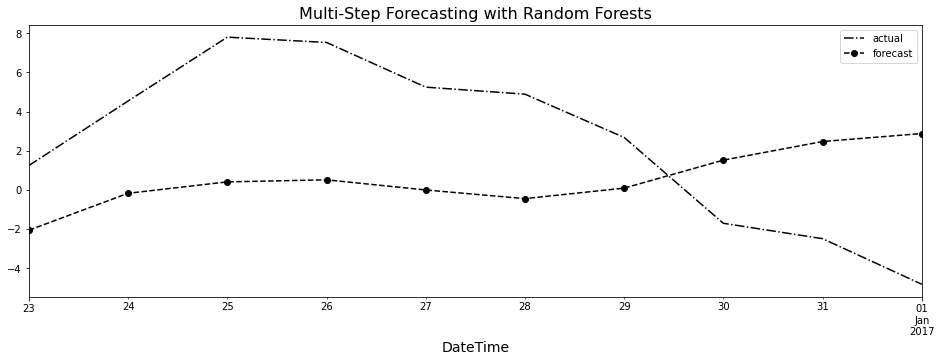

In [613]:
dw_ms = X_test.iloc[-1].values
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=10, model=rf))

actual = dw_cp.iloc[-10:]

ax = actual.plot(style='k-.')
pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Random Forests')
plt.legend(['actual', 'forecast'])


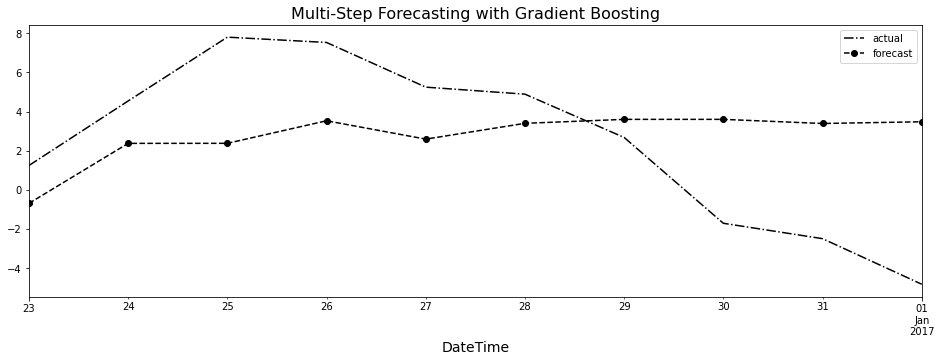

In [614]:
dw_ms = X_test.iloc[-1].values
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=10, model=gb))

actual = dw_cp.iloc[-10:]

ax = actual.plot(style='k-.')
pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Gradient Boosting')
plt.legend(['actual', 'forecast'])

<AxesSubplot:xlabel='DateTime'>

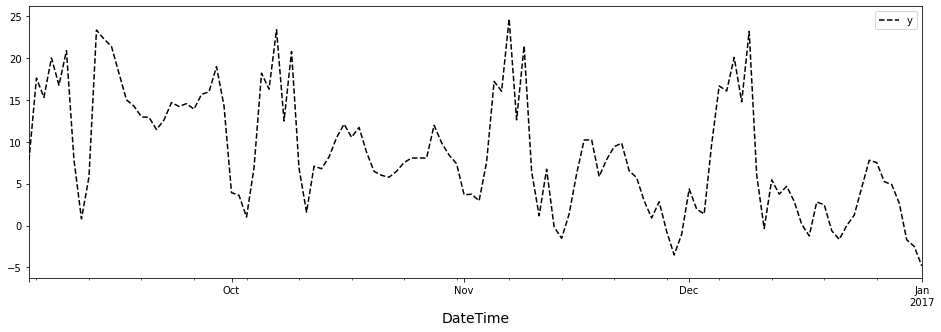

In [621]:
dw_cp.iloc[-120:].plot(style='k--')

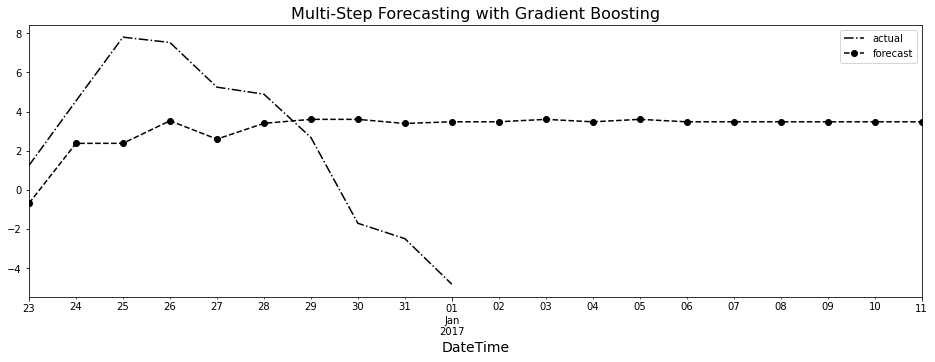

In [631]:
steps = 20
actual = dw_cp.iloc[-10:]
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=gb))
idx = pd.date_range(dw_cp.index[-10], periods=steps)
ax = actual.plot(style='k-.')
pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Gradient Boosting')
plt.legend(['actual', 'forecast'])

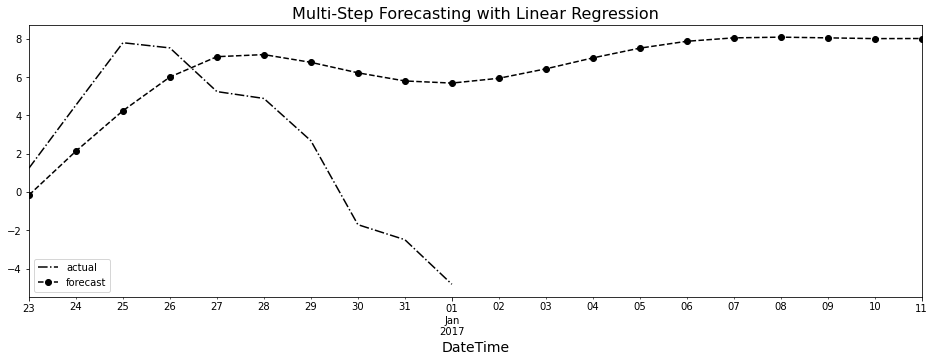

In [632]:
actual = dw_cp.iloc[-10:] 
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=lr))
idx = pd.date_range(dw_cp.index[-10], periods=steps)
ax = actual.plot(style='k-.')
pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Linear Regression')
plt.legend(['actual', 'forecast'])

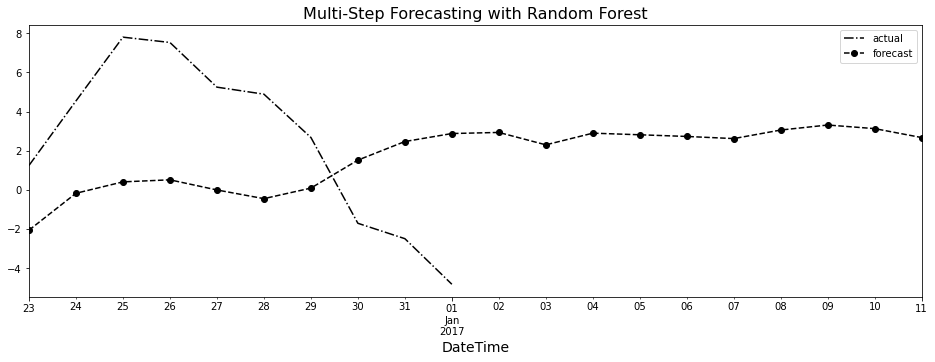

In [635]:
actual = dw_cp.iloc[-10:]
pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=rf))
idx = pd.date_range(dw_cp.index[-10], periods=steps)
ax = actual.plot(style='k-.')
pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
plt.title('Multi-Step Forecasting with Random Forest')
plt.legend(['actual', 'forecast'])

In [591]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()

In [592]:
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [386]:
def multi_step_forecast(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [113]:
i , o = 7, 7
d = multi_step_forecast(dw_cp, i, o)

2916


In [114]:
d.shape

(2910, 14)

In [115]:
train, test = split_data(d)

In [116]:
ss = Standardize()
train_s , test_s = ss.fit_transform(train, test)

In [118]:
X_train, y_train = train_s.iloc[:, 0:i] , train_s.iloc[:, i:]

In [221]:
X_train.shape

(2474, 7)

In [120]:
X_test, y_test = test_s.iloc[:, 0:i] , test_s.iloc[:, i:]

In [260]:
lr = Lasso(fit_intercept=False, alpha=0.5)

In [261]:
lr.fit(X_train.values, y_train.values)

Lasso(alpha=0.5, fit_intercept=False)

In [262]:
rf.fit(X_train.values, y_train.values)

RandomForestRegressor()

In [488]:
#gb.fit(X_train.values, y_train.values)

In [240]:
lr.predict(X_test).shape

(436, 7)

In [241]:
y_test.iloc[:, -1].shape

(436,)

In [242]:
X_test.iloc[[-1]]

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-19 -0.873272 -1.268142 -1.401182 -1.191325 -1.032513 -0.615844   

                 x_7  
DateTime              
2016-12-19 -0.203734

In [243]:
dw_cp.tail(7)

y
DateTime            
2016-12-26  7.527431
2016-12-27  5.245625
2016-12-28  4.887153
2016-12-29  2.676250
2016-12-30 -1.706597
2016-12-31 -2.492500
2017-01-01 -4.820000

In [244]:
ss.inverse_y(y_test.iloc[[-1]])

y_1       y_2       y_3       y_4      y_5       y_6  \
DateTime                                                                
2016-12-19  7.531681  5.251379  4.896857  2.683867 -1.70974 -2.500034   

                 y_7  
DateTime              
2016-12-19 -4.842393

In [245]:
(X_test.iloc[[-1]]).values.reshape(-1)

array([-0.87327233, -1.26814177, -1.40118242, -1.19132516, -1.03251329,
       -0.61584389, -0.20373401])

In [246]:
m_yhat = ss.inverse_y(lr.predict(X_test.iloc[[-1]]))
m_yhat

array([[9.00433836, 9.2744772 , 9.41218461, 9.41218461, 9.41218461,
        9.41218461, 9.41218461]])

In [255]:
m_yhat = ss.inverse_y(rf.predict(X_test.iloc[[-1]]))
m_yhat

array([[3.74422374, 6.1085703 , 5.90785492, 6.75791034, 7.15278449,
        8.04571415, 7.90964765]])

In [256]:
dw_cp.index[-14:-7]

DatetimeIndex(['2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-24', '2016-12-25'],
              dtype='datetime64[ns]', name='DateTime', freq='D')

In [257]:
dw_cp.index[-7:]

DatetimeIndex(['2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='DateTime', freq='D')

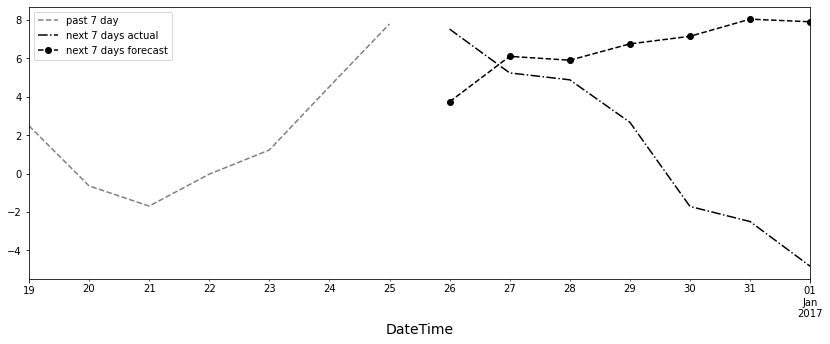

In [258]:
last_7_days = ss.inverse_y(X_test.iloc[[-1]]).values.reshape(-1)
next_7_days_actual = dw_cp.iloc[-7:]
next_7_days_predicted = m_yhat.reshape(-1)

ax = pd.Series(last_7_days, index=dw_cp.index[-14:-7]).plot(style='k--', alpha=0.5)
next_7_days_actual.plot(style='k-.', ax=ax)
pd.Series(next_7_days_predicted, index=dw_cp.index[-7:]).plot(style='k--o', ax=ax)
plt.legend(['past 7 day', 'next 7 days actual', 'next 7 days forecast'])

# Using non linear models

In [18]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [19]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_weather.copy()

### Preprocessing Time Series Data

In [20]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [21]:
air_nm = one_step_forecast(air_cp, 10)
en_nm = one_step_forecast(en_cp, 10)
dw_nm = one_step_forecast(dw_cp, 10)

In [22]:
print(air_nm.shape)
print(en_nm.shape)
print(dw_nm.shape)

(134, 11)
(578, 11)
(2913, 11)


In [23]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [24]:
train_air, test_air = split_data(air_nm, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

In [25]:
train_en, test_en = split_data(en_nm, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

In [26]:
train_dw, test_dw = split_data(dw_nm, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_en.fit_transform(train_dw,test_dw)

### Train

In [27]:
regressors = {
    'Random Forest': RandomForestRegressor(),
    'SVM':SVR(),
    'K-Nearest Neighbors':KNeighborsRegressor(),
    'ExtraTree': ExtraTreesRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Histogram Gradient Boosting': HistGradientBoostingRegressor(),
    'Radius Neighbors': RadiusNeighborsRegressor()}

In [1]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

NameError: name 'train_different_models' is not defined

### Evaluate

In [85]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.210168  1.390807
0  Linear Regression  0.385559  0.213810  1.411072
4   Huber Regression  0.400949  0.226859  1.457932
1        Elastic Net  0.829023  0.406390  2.808737
3   Lasso Regression  1.190006  0.780255  4.439302

In [86]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  0.729910  0.525526
2   Ridge Regression  0.433192  0.819432  0.560450
0  Linear Regression  0.433747  0.818459  0.560989
1        Elastic Net  0.747657  1.398025  1.013425
3   Lasso Regression  0.834356  1.502494  1.108092

In [87]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  0.697774  0.968735
0  Linear Regression  0.646648  0.735055  0.990057
2   Ridge Regression  0.646639  0.735072  0.990085
1        Elastic Net  0.737896  1.075669  1.300792
3   Lasso Regression  0.814609  1.304278  1.468567

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

### Air Passengers Plots

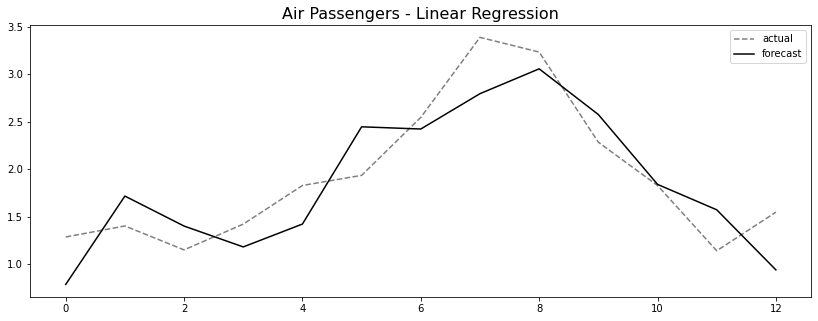

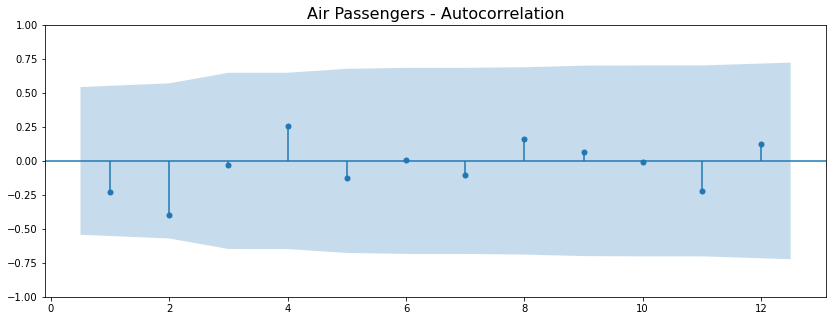

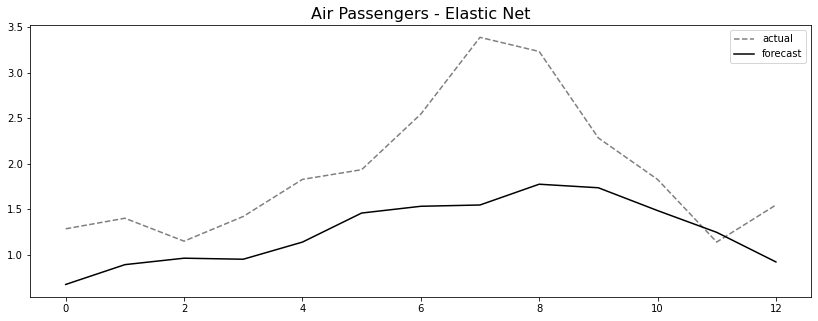

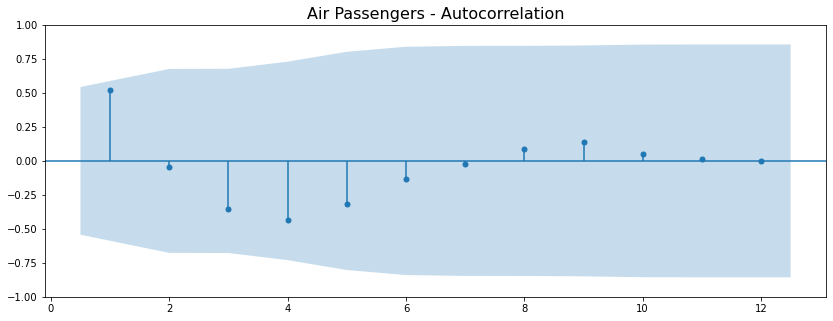

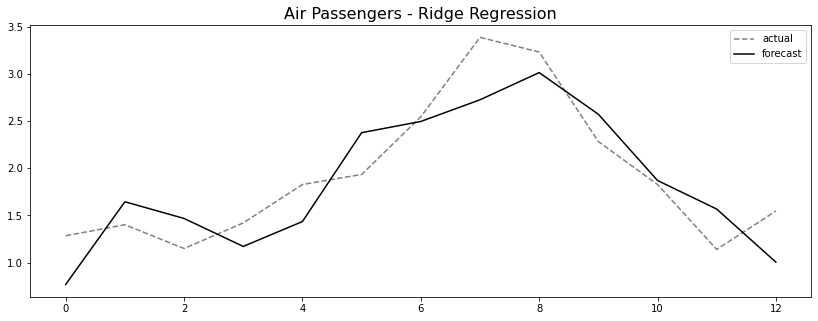

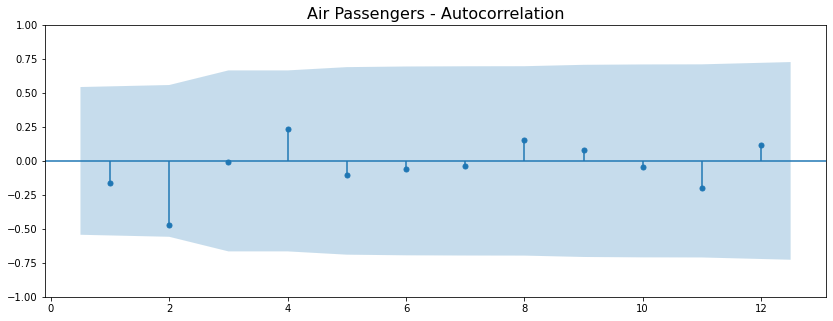

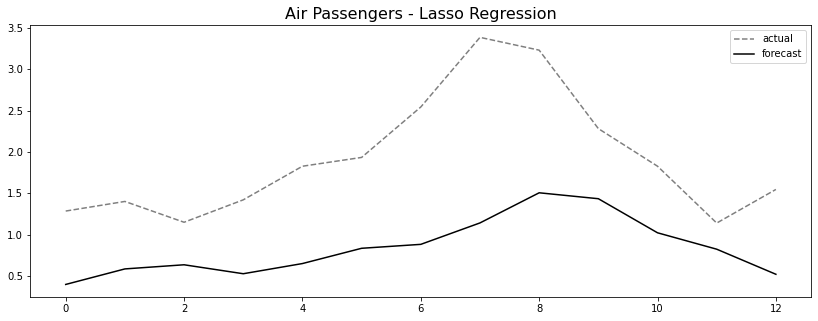

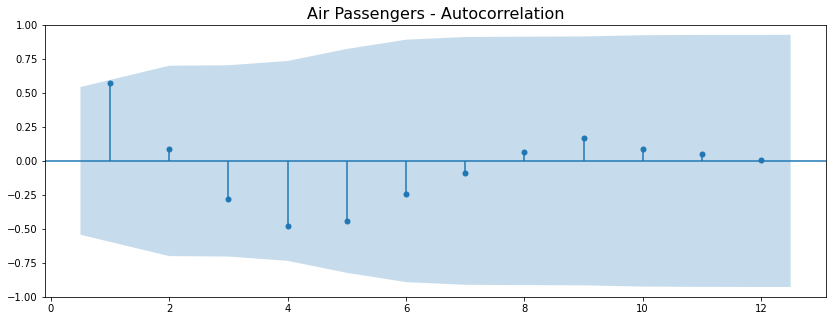

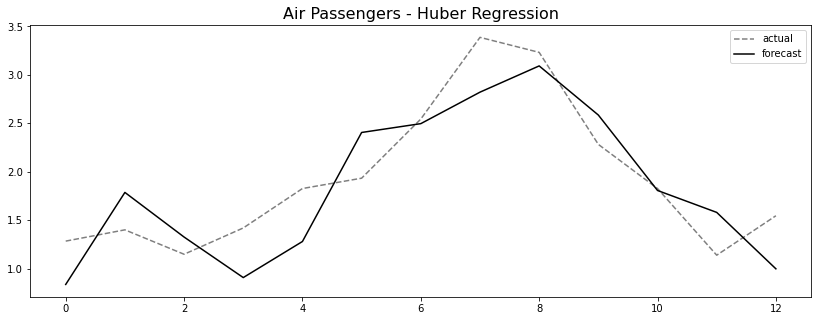

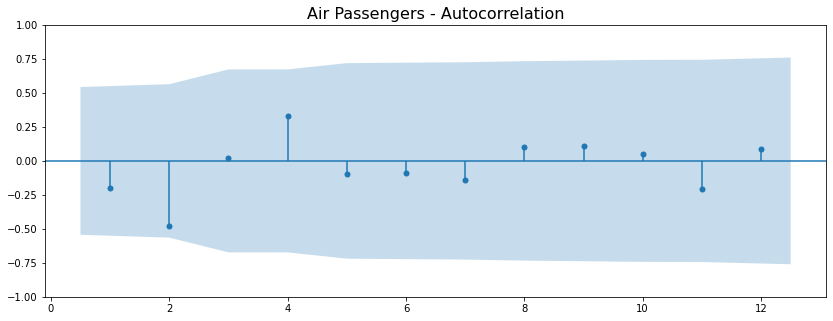

In [38]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


## There is more

### Multi-Step Forecasting with Non Linear Models

In [ ]:
dw_ms = X_test.iloc[-1].values
pred = multi_step(dw_ms, steps=10, model=lr)
pred

In [164]:
full_data = df_diff.drop(columns=['y'])
y_actual = df_diff['y']

In [165]:
y_hat = lr.predict(full_data)


In [166]:
residuals = y_actual - y_hat

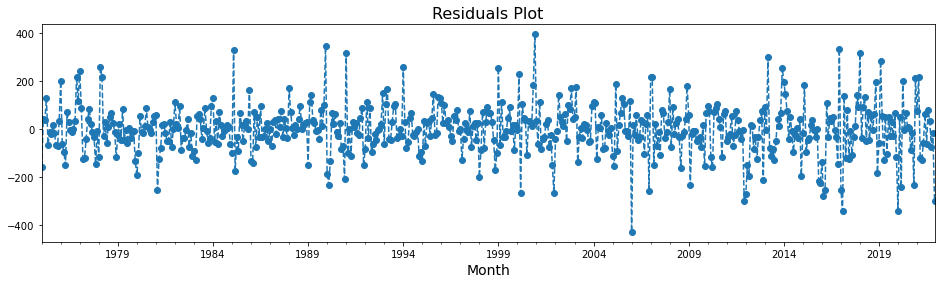

In [167]:
residuals.plot(style='o--', title='Residuals Plot')
plt.savefig('images/fig_12.13.png', bbox_inches='tight')

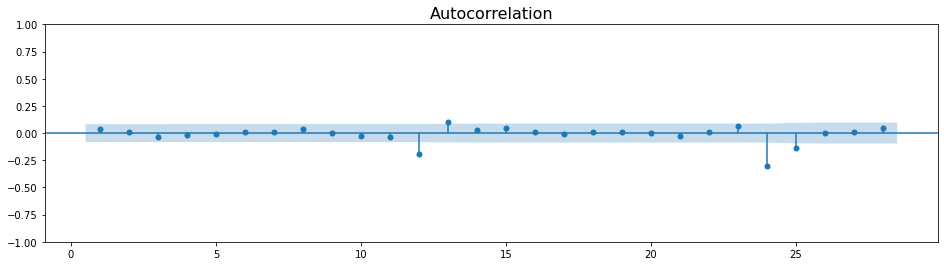

In [174]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, zero=False)
plt.savefig('images/fig_12.14.png', bbox_inches='tight')
plt.show()

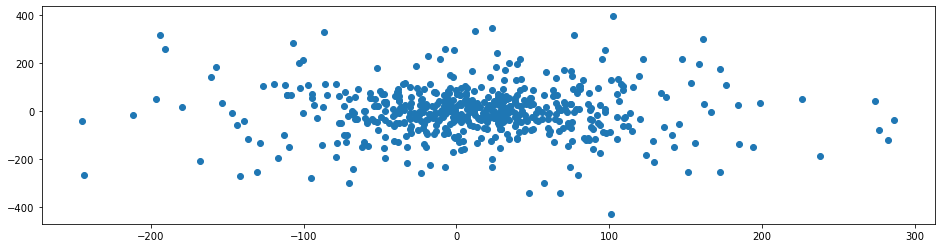

In [175]:
plt.scatter(y_hat, residuals)
plt.savefig('images/fig_12.15.png', bbox_inches='tight')

# Forecasting with sktime

Loading required modules

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction
import warnings

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

Importing plotly failed. Interactive plots will not work.


In [266]:
import sktime
sktime.__version__

'0.11.0'

Loading the dataset and inspecting the data

In [180]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

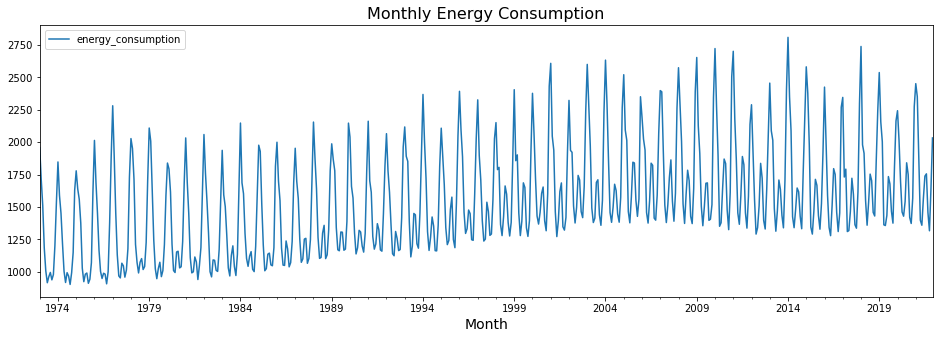

In [181]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [28]:
df.head()

energy_consumption
Month                         
1973-01-01            1957.641
1973-02-01            1712.143
1973-03-01            1510.079
1973-04-01            1183.421
1973-05-01            1006.326

In [29]:
df.tail()

energy_consumption
Month                         
2021-08-01            1755.212
2021-09-01            1456.901
2021-10-01            1315.799
2021-11-01            1644.306
2021-12-01            2032.352

In [30]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [31]:
df.shape

(588, 1)

**Different ways to split your time series**


In [32]:
# using sklearn
from sklearn.model_selection import train_test_split
train, teset = train_test_split(df, test_size=24, shuffle=False)

# using sktime 
train, test = temporal_train_test_split(df, test_size=24)

# pandas slicing
size = 24
train, test = df.iloc[:-size], df.iloc[-size:]

train.columns = ['train']
test.columns = ['test']

In [33]:
test

test
Month               
2020-01-01  2242.462
2020-02-01  2011.541
2020-03-01  1692.834
2020-04-01  1460.650
2020-05-01  1428.359
2020-06-01  1541.875
2020-07-01  1840.435
2020-08-01  1750.274
2020-09-01  1419.171
2020-10-01  1372.201
2020-11-01  1567.707
2020-12-01  2274.277
2021-01-01  2451.101
2021-02-01  2350.977
2021-03-01  1856.031
2021-04-01  1397.144
2021-05-01  1358.566
2021-06-01  1564.205
2021-07-01  1737.442
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

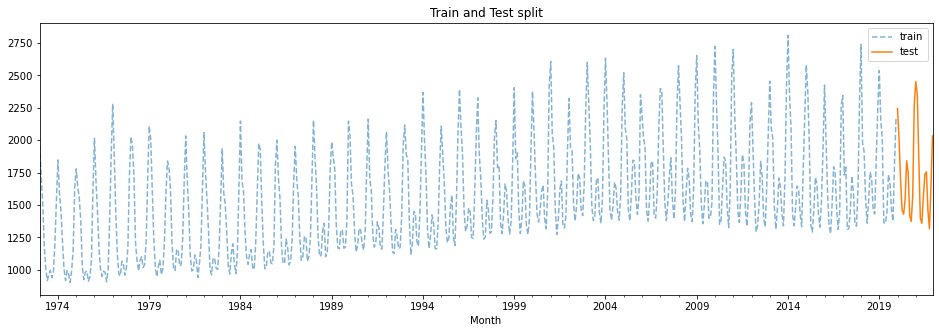

In [34]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [35]:
test.shape

(24, 1)

In [36]:
test.tail()

test
Month               
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

In [37]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [38]:
adfuller(df)

(-1.449733113243752,
 0.5582151234544165,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

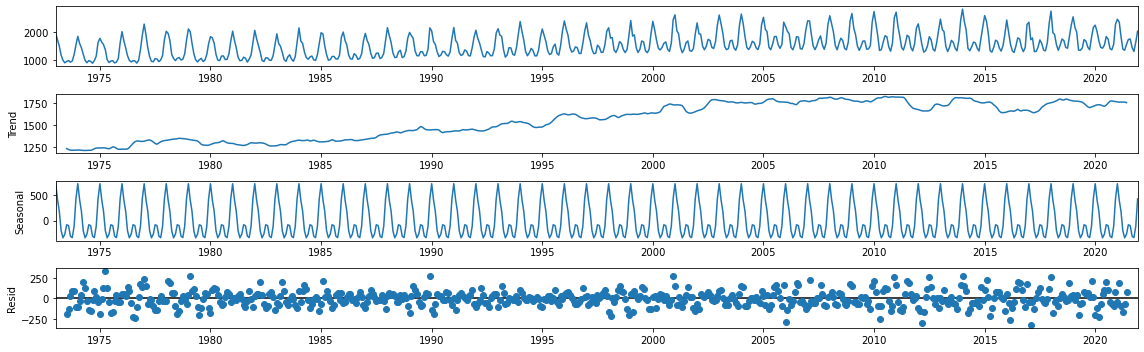

In [39]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [40]:
test.index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [225]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [42]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [43]:
test.shape

(24, 7)

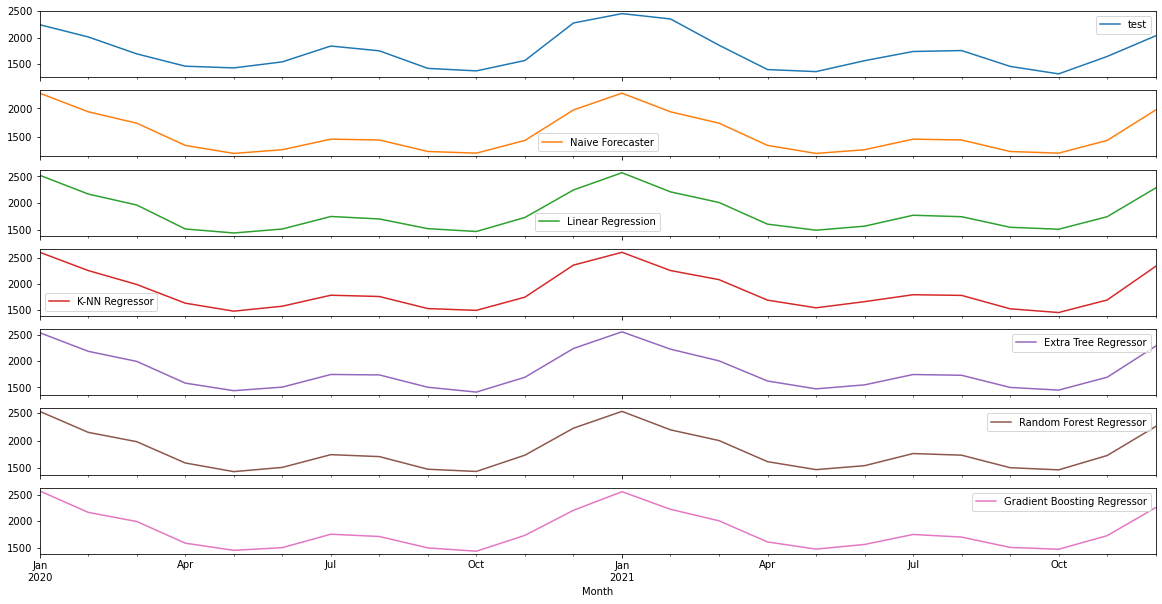

In [44]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

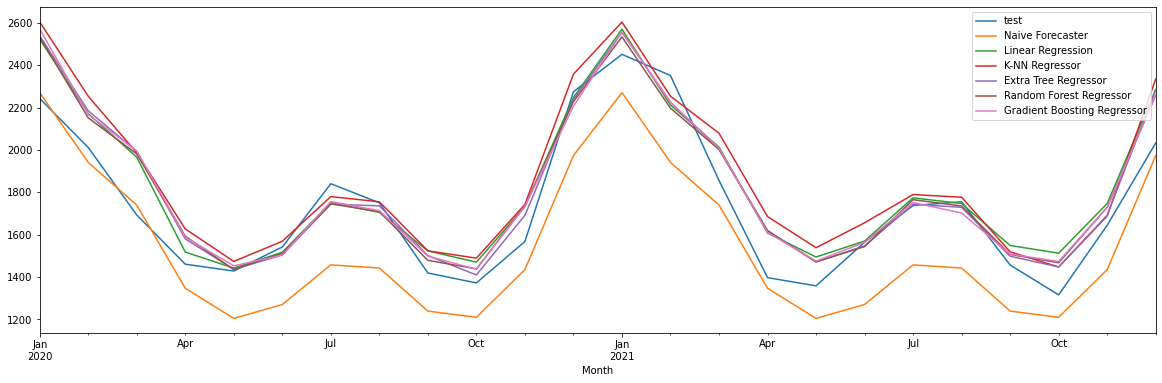

In [45]:
test.plot(subplots=False, figsize=(20, 6))

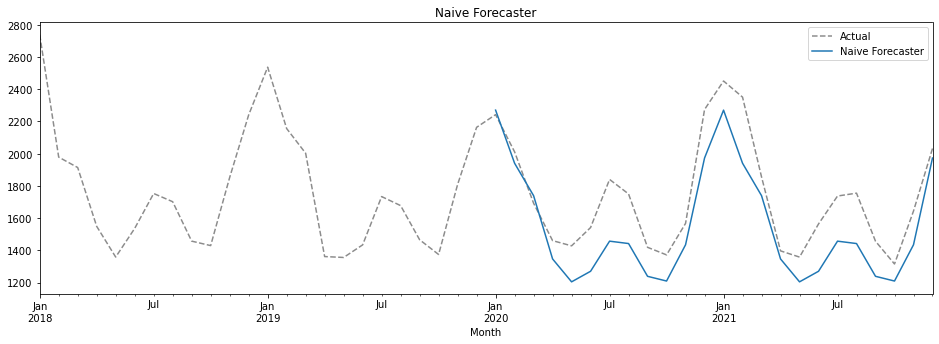

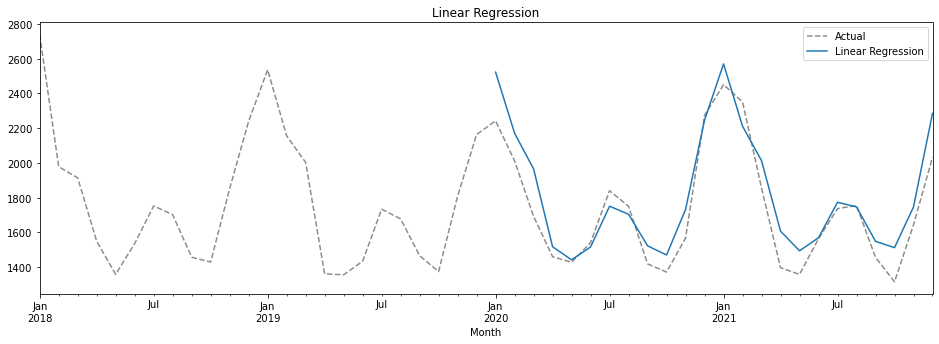

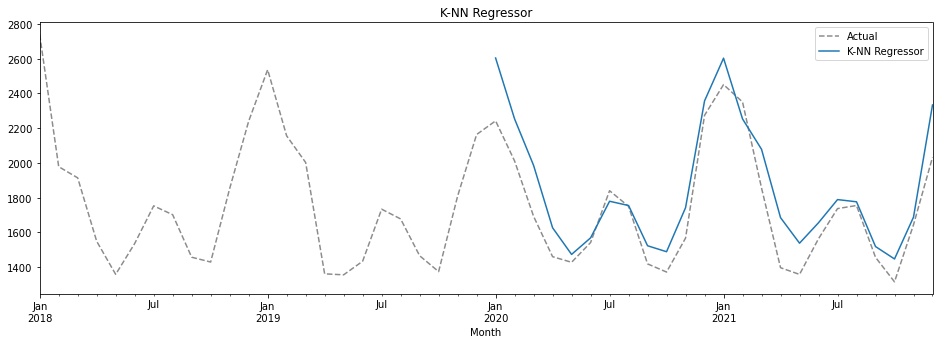

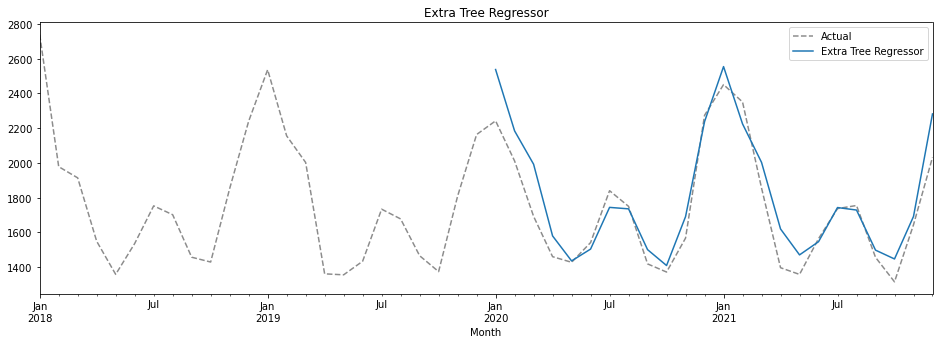

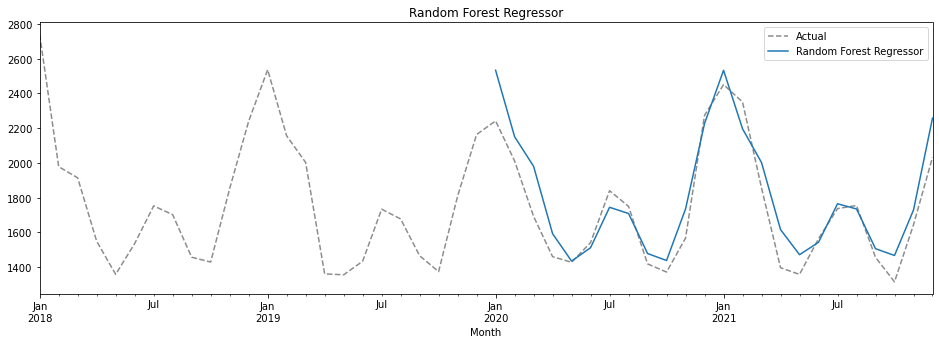

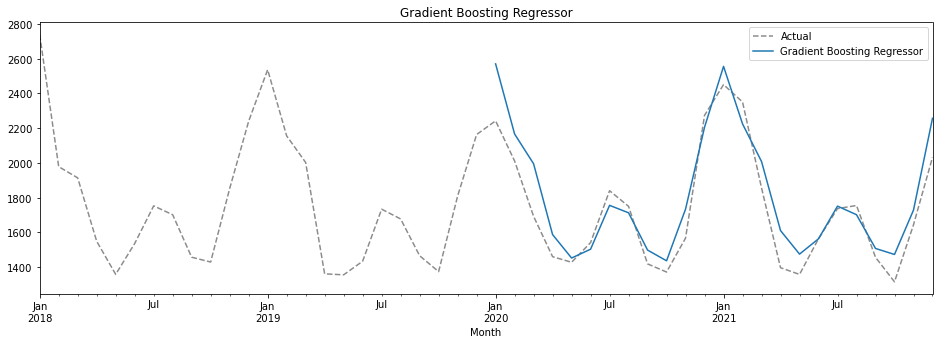

In [46]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [226]:
def evaluate(df, sort_by='sMAPE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['test']
    y_predicted = df.drop(columns=['test'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
    return evals.T.sort_values(by=sort_by)
    

In [48]:
evaluate(test)

sMAPE      MAPE        RMSE
Extra Tree Regressor         0.058853  0.061459  137.371526
Random Forest Regressor      0.061911  0.064536  137.417509
Gradient Boosting Regressor  0.064279  0.067125  142.967258
Linear Regression            0.065325  0.068308  142.176939
K-NN Regressor               0.076512  0.080899  170.178191
Naive Forecaster             0.121355  0.112677  219.987776

In [49]:
evaluate(test, sort_by='RMSE')

sMAPE      MAPE        RMSE
Extra Tree Regressor         0.058853  0.061459  137.371526
Random Forest Regressor      0.061911  0.064536  137.417509
Linear Regression            0.065325  0.068308  142.176939
Gradient Boosting Regressor  0.064279  0.067125  142.967258
K-NN Regressor               0.076512  0.080899  170.178191
Naive Forecaster             0.121355  0.112677  219.987776

## There is more

In [28]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [29]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  564
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -3338.554
Date:                                 Fri, 08 Apr 2022   AIC                           6691.108
Time:                                         03:27:28   BIC                           6721.441
Sample:                                              0   HQIC                          6702.949
                                                 - 564                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.006      0.106      0.916      -0.011       0.012
ar.L1          0.4767      0.034     14.071      0.000       0.410       0.543
ma.L1         -0.9748      0.010   -102.212      0.000      -0.993      -0.956
ar.S.L12       0.9978      0.002    612.650      0.000       0.995       1.001
ma.S.L12      -0.7217      0.028    -25.434      0.000      -0.777      -0.666
ma.S.L24      -0.0871      0.012     -7.308      0.000      -0.110      -0.064
sigma2      7804.8584    340.564     22.917      0.000    7137.366    8472.351
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                97.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test['ARIMA'] = arima.predict(n)

In [31]:
test.shape

(24, 8)

In [32]:
test.head()

test  Naive Forecaster  Linear Regression  K-NN Regressor  \
Month                                                                       
2020-01-01  2242.462       2270.323702        2522.814708     2604.277175   
2020-02-01  2011.541       1940.863681        2171.116655     2253.460503   
2020-03-01  1692.834       1739.600298        1965.760283     1985.997768   
2020-04-01  1460.650       1347.089489        1517.825403     1627.154399   
2020-05-01  1428.359       1204.958617        1442.385026     1473.659183   

            Extra Tree Regressor  Random Forest Regressor  \
Month                                                       
2020-01-01           2528.933594              2536.450796   
2020-02-01           2178.930967              2151.040212   
2020-03-01           1977.476754              1952.271006   
2020-04-01           1594.253255              1584.834951   
2020-05-01           1433.401763              1442.829907   

            Gradient Boosting Regressor        ARIMA  
Month                                                 
2020-01-01                  2570.473160  2506.947375  
2020-02-01                  2166.817111  2084.300249  
2020-03-01                  1995.332132  1900.006095  
2020-04-01                  1587.730558  1407.773645  
2020-05-01                  1452.865700  1347.337206

In [33]:
evaluate(test)

sMAPE      MAPE        RMSE
ARIMA                        0.042925  0.043336  108.738816
Extra Tree Regressor         0.061623  0.064157  135.904756
Random Forest Regressor      0.061705  0.064394  138.827577
Gradient Boosting Regressor  0.064279  0.067125  142.967258
Linear Regression            0.065325  0.068308  142.176939
K-NN Regressor               0.076512  0.080899  170.178191
Naive Forecaster             0.121355  0.112677  219.987776

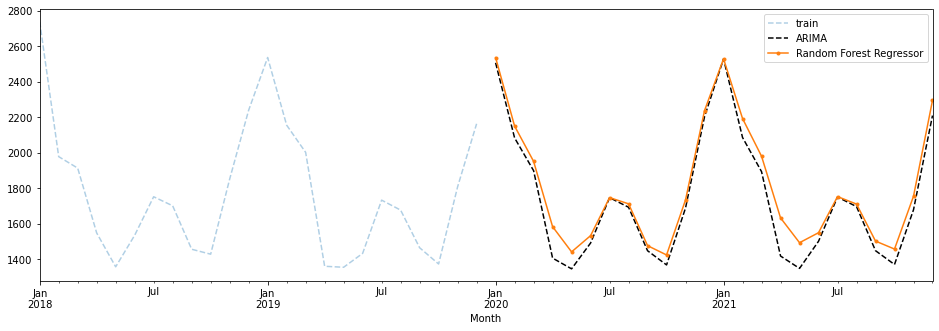

In [34]:
ax = train.loc['2018':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k--')
test['Random Forest Regressor'].plot(ax=ax, style='.-')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend()

## Manual

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Optimizing a Machine Learning model with Hyperparameter Tuning

In [184]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [31]:
file = Path('../../datasets/Ch12/Residential_Energy_Consumption.xlsx')
col = ['Month','Total Energy Consumed by the Residential Sector']
df = pd.read_excel(file, index_col='Month', usecols=col)
df.columns = ['energy_consumption']

In [32]:
train, test = temporal_train_test_split(df, test_size=24)
train.columns = ['train']
test.columns = ['test']
train.shape

(564, 1)

In [33]:
test.shape

(24, 1)

In [34]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                RandomForestRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [35]:
forecaster.fit(train.values)
test['RandomForestRegressor'] = forecaster.predict(fh)

In [36]:
test.head()

test  RandomForestRegressor
Month                                      
2020-01-01  2242.462            2567.523434
2020-02-01  2011.541            2198.274815
2020-03-01  1692.834            1962.437646
2020-04-01  1460.650            1513.020806
2020-05-01  1428.359            1375.816806

In [37]:
evaluate(test)

sMAPE      MAPE        RMSE
RandomForestRegressor  0.062807  0.065323  144.288861

In [38]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__bootstrap': True,
 'forecast__estimator__ccp_alpha': 0.0,
 'forecast__estimator__criterion': 'squared_error',
 'forecast__estimator__max_depth': None,
 'forecast__estima

In [39]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'detrend__forecaster', 'forecast__estimator__bootstrap', 'forecast__estimator__ccp_alpha', 'forecast__estimator__criterion', 'forecast__estimator__max_depth', 'forecast__estimator__max_features', 'forecast__estimator__max_leaf_nodes', 'forecast__estimator__max_samples', 'forecast__estimator__min_impurity_decrease', 'forecast__estimator__min_samples_leaf', 'forecast__estimator__min_samples_split', 'forecast__estimator__min_weight_fraction_leaf', 'forecast__estimator__n_estimators', 'forecast__estimator__n_jobs', 'forecast__estimator__oob_score', 'forecast__estimator__random_state', 'forecast__estimator__verbose', 'forecast__estimator__warm_start', 'forecast__estimator', 'forecast__window_length'])

In [223]:
# large grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 300, 500, 1000],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__max_depth": [None] + [int(x) for x in np.linspace(2, 20, num = 10)],
    "forecast__estimator__min_samples_split": [2, 5, 7],
    "forecast__estimator__min_samples_leaf": [1, 2, 4],
    "forecast__estimator__bootstrap": [True, False],
    "forecast__window_length": [10, 12, 15],
    "forecast__estimator__ccp_alpha": [0.0, 0.005, 0.01]
}

In [40]:
#smaller grid search space
hyperparams_grid = {
    "forecast__estimator__n_estimators": [100, 500],
    "forecast__estimator__max_depth": [None, 2, 4],
    "forecast__estimator__min_samples_split": [2, 3, 5],
    "forecast__window_length": [10, 12, 15],
}


cv = SlidingWindowSplitter(window_length=int(len(df) * 0.90), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv, 
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [41]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529)

In [203]:
grid_csv.fit(df.values)

Fitting 36 folds for each of 54 candidates, totalling 1944 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', is_relative=True),
           window_length=529),
                        forecaster=TransformedTargetForecaster(steps=[('deseasonalize',
                                                                       Deseasonalizer(model='multiplicative',
                                                                                      sp=12)),
                                                                      ('detrend',
                                                                       Detrender()),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                         

In [211]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize',
                                    Deseasonalizer(model='multiplicative',
                                                   sp=12)),
                                   ('detrend', Detrender()),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                                                         min_samples_split=5,
                                                                                                         n_estimators=500),
                                                                         window_length=12))])

In [212]:
grid_csv.best_params_

{'forecast__estimator__max_depth': 4,
 'forecast__estimator__min_samples_split': 5,
 'forecast__estimator__n_estimators': 500,
 'forecast__window_length': 12}

In [227]:
grid_csv.cv_results_

In [214]:
test['RandomForestRegressor_optim'] = grid_csv.predict(fh)

In [215]:
evaluate(test)

sMAPE      MAPE        RMSE
RandomForestRegressor_optim  0.052736  0.054957  128.603376
RandomForestRegressor        0.061285  0.063601  137.970780

In [216]:
model = grid_csv.best_forecaster_

In [217]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender()),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                        min_samples_split=5,
                                                                        n_estimators=500),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                      min_samples_split=5,
                                                                      n_estimators=500),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': None,
 'forecast__estimator__bootst

# Multivariate Forecasting and Ensemble Learning with sktime

In [246]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [247]:
load_macroeconomic().shape

(203, 12)

In [248]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [249]:
econ_df.shape

(203, 5)

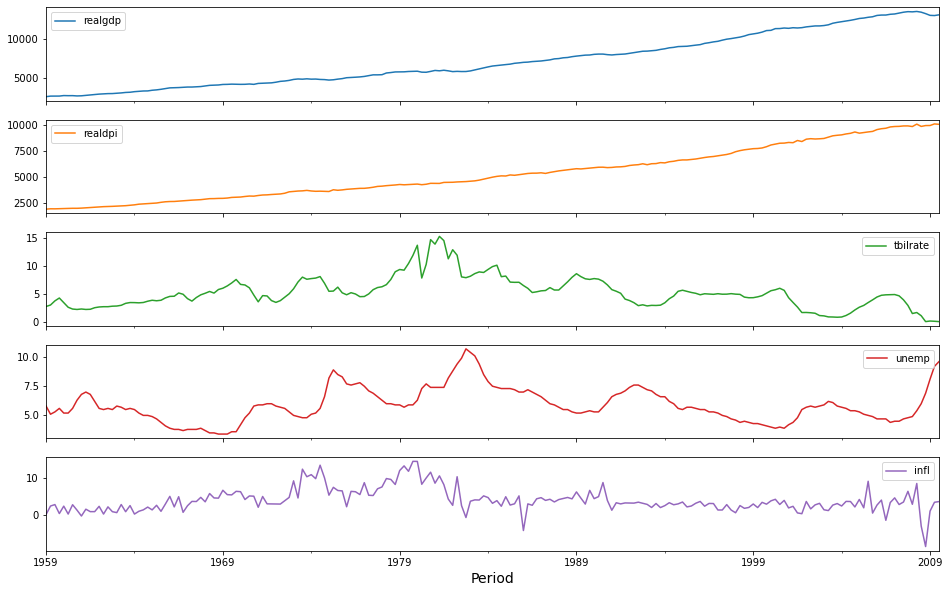

In [250]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [251]:
econ_df.head()

realgdp  realdpi  tbilrate  unemp  infl
Period                                          
1959Q1  2710.349   1886.9      2.82    5.8  0.00
1959Q2  2778.801   1919.7      3.08    5.1  2.34
1959Q3  2775.488   1916.4      3.82    5.3  2.74
1959Q4  2785.204   1931.3      4.33    5.6  0.27
1960Q1  2847.699   1955.5      3.50    5.2  2.31

In [252]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [253]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [254]:
test_size = 12
y_train, y_test = temporal_train_test_split(y, test_size=test_size)
exog_train, exog_test = temporal_train_test_split(exog, test_size=test_size)

In [255]:
regressors = [
        ("LinearRegression", make_reduction(LinearRegression())),
        ("RandomForest", make_reduction(RandomForestRegressor())),
        ("SupportVectorRegressor", make_reduction(SVR())),
        ("GradientBoosting", make_reduction(GradientBoostingRegressor()))
    ]

In [256]:
ensemble = EnsembleForecaster(regressors)
rf = make_reduction(RandomForestRegressor())

In [257]:
ensemble.fit(y=y_train, X=exog_train)
rf.fit(y=y_train, X=exog_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())

In [258]:
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['RandomForest'] = rf.predict(fh=fh, X=exog_test)

In [261]:
evaluate(y_hat)

sMAPE      MAPE      RMSE
RandomForest        0.965133  8.666123  2.338473
EnsembleForecaster  1.051301  3.828983  1.702995

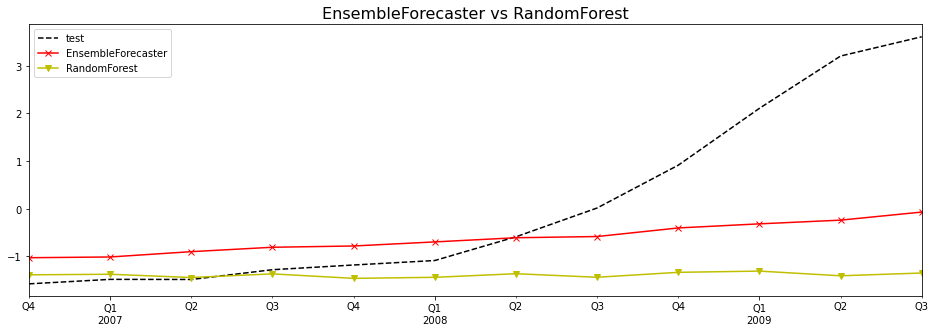

In [265]:
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs RandomForest')
plt.legend()
plt.savefig('images/fig_12.24.png', bbox_inches='tight', dpi=300)
plt.show()

In [501]:
multi_grid.best_params_

{'selected_forecaster': 'GradientBoosting'}

In [500]:
multi_grid.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                               0.287071       0.016769        0.006967   
1                               0.108129       0.305849        0.068155   
2                               0.303801       0.015557        0.006060   
3                               0.105496       0.190713        0.007355   

                                              params  \
0        {'selected_forecaster': 'LinearRegression'}   
1            {'selected_forecaster': 'RandomForest'}   
2  {'selected_forecaster': 'SupportVectorRegressor'}   
3        {'selected_forecaster': 'GradientBoosting'}   

   rank_test_MeanAbsolutePercentageError  
0                                    3.0  
1                                    2.0  
2                                    4.0  
3                                    1.0

## There is more

In [282]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [283]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [284]:
auto.weights_

[0.1992846306188651,
 0.17097181125615227,
 0.38045734892465477,
 0.24928620920032785]

In [285]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

In [276]:
evaluate(y_hat)

sMAPE       MAPE      RMSE
RandomForest            0.965133   8.666123  2.338473
AutoEnsembleForecaster  1.004482  10.847680  2.574099
EnsembleForecaster      1.051301   3.828983  1.702995